# Industrial production forecasting

## Introduction

Presentations elements:
- Description of the dataset and data preprocessing
- Description of the design of our forecasting pipeline
- Baseline scenario: forecasting industrial production 6 month ahead (we use 6 month instead of 12 which is used in the paper we rely on because we forecast industrial production which is a coincident economic indicator, while the authors of the paper forecast change in unemployment which is a lagging indicator). We use validation folds for hyperparameter tuning, while the test subset is used to compare the models. We use standardized data + the first lag of our feature space in baseline scenario. 
- After we have fitted our models, we also run feature importance tests (permutation importance and shap values) on the test subset
-----
- We should have a table with validation folds mean and test subset MAE across the models
- A table of comparison of running the models on the whole feature space and on principal components
- A table of comparison of running the models on different lags 
- A table

Goals:
- Build predictive (and nowcasting) pipeline for US industrial production
- Build a similar pipeline for the UK, and Canada 
- Evaluate spillover effects or lead/lag effects in terms of economic activity in trading partners (e.g. Canada and U.S.)

To do:
- Build a function that takes as input a model (with specified parameters) and gives back: (a) performance on test/train/val samples; (b) data for visualizations of prediction quality (also compare YoY changes with MoM) - should be able to see rolling samples and errors (also with different prediction horizons).
- Build a visualization function for the task above.
- Use PCA transformed data (make sure that rolling transformations use the same rotation)
- Use raw data with regularization
- Build predictive regression model (actual value)
- Build predictive classification model (6 month of negative industrial production growth vs. FRED recessions)
- Apply feature importance methods (shaply values, permutations)
- Apply the pipeline to Canadian data, and to the data from the UK
- Augment feature space for Canada and for the UK with the data from the US 

Sources:
- https://s3.amazonaws.com/real.stlouisfed.org/wp/2015/2015-012.pdf (Original paper)
- https://research.stlouisfed.org/econ/mccracken/fred-databases/ 
- https://www.cambridge.org/core/journals/national-institute-economic-review/article/can-machine-learning-catch-the-covid19-recession/AB27EF7A1A59166C186AC2619110DB4C
- http://www.stevanovic.uqam.ca/DS_UKMD.html
- http://www.stevanovic.uqam.ca/DS_LCMD.html
- https://medium.com/@hallmark-nick/deep-learning-in-macroeconomic-forecasting-us-unemployment-cbcc5a33c7c9 (for cross-validation)

In [382]:
target_variable = "INDPRO"

## Imports

In [383]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 6)

from statsmodels.tsa.stattools import adfuller

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, f1_score

import pandas_datareader as pdr

# feature importance
from sklearn.inspection import permutation_importance
import shap

In [384]:
#df = pd.read_csv("https://files.stlouisfed.org/files/htdocs/fred-md/monthly/2024-01.csv", header=0)
#df.head()

In [385]:
#df.to_csv("2024_01.csv")

In [386]:
df = pd.read_csv("2024_01.csv")
df.drop(columns = ['Unnamed: 0'], inplace=True)
df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0000,1.0
1,1/1/1959,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9665,23.3891,22.2688,31.7011,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3966,23.7048,22.4617,31.9337,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7193,23.8483,22.5719,31.9337,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,283362.7075,18534.46600,23.2032,24.1927,22.9026,32.4374,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN


In [387]:
us_recession = pdr.DataReader(['USREC'], 'fred', start="1960-01-01", end="2023-06-01")

## Transformations

In [388]:
def transform(df=df):

    # transformations codes
    transformations = df.iloc[0,:].copy()
    transformations.name = 'Transformations'
    transformations.drop("sasdate", inplace=True)

    # actual data
    data = df.iloc[1:,:].copy()
    data.index = data["sasdate"]
    del data["sasdate"]

    data.index = pd.to_datetime(data.index)

    # drop columns with many missing values
    drop_list = [
             'ACOGNO', 
             'ANDENOx', 
             'TWEXAFEGSMTHx', 
             'UMCSENTx', 
             'VIXCLSx' # 30 months missing at the beginning of the sample
             ]
    data = data.drop(columns=drop_list)
    transformations = transformations.drop(drop_list)

    # fill missing values 
    data = data.interpolate(method="linear") # only for two series

    def func(x, code):

        if code == 1:
            return x
        elif code == 2:
            return x.diff(1)
        elif code == 3:
            return x.diff(1).diff(1)
        elif code == 4:
            return np.log(x)
        elif code == 5:
            return np.log(x).diff(1)
        elif code == 6:
            return np.log(x).diff(1).diff(1)
        elif code == 7:
            return (x / x.shift(1) - 1).diff(1)
        
    transformed = data.apply(lambda col: func(col, code = transformations[col.name]))

    # exclude the last 6 months and the first 12 months
    transformed = transformed.iloc[12:-6]

    return transformed

In [389]:
data = transform(df)

HOUST 0.055248244571582034
HOUSTNE 0.17420288210464496
HOUSTMW 0.16503485473214075
PERMITNE 0.08914097885628541
PERMITMW 0.10470949579138955


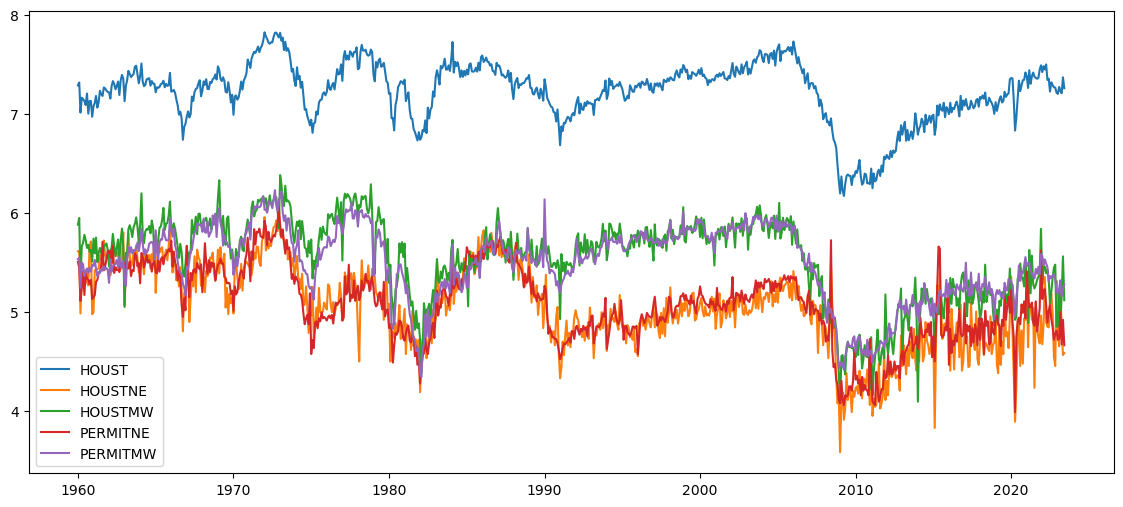

In [390]:
potentially_non_stationary = []

for c in data.columns:
    pvalue = adfuller(data[c])[1] 
    if pvalue > 0.05:
        print(c, pvalue)
        potentially_non_stationary.append(c)


fig, ax = plt.subplots()

for c in potentially_non_stationary:
    ax.plot(data[c], label = c)

ax.legend()
plt.show()

We use the data up to January 1993 for training, and later data for validation. For the purposes of standardisation, we use compute means and stds for the entire sample up to 1993, and after that change them as new observations arrive. # 93 - 23; 93 - 03, 03 - 13, 13 - 23  

In [391]:
def dynamic_normalization(df, cutoff_date = '1993-01-01'):
  
    num_cutoff = df.index.get_loc(cutoff_date)
    df_before = df[:num_cutoff]

    means_before = df_before.mean()
    stds_before = df_before.std()
    
    normalized = (df_before - means_before) / stds_before

    for i in range(num_cutoff, len(df)):
        new_obs = (df[:i] - df[:i].mean()) / df[:i].std()
        last_data_point = pd.DataFrame(new_obs.iloc[-1]).T
        normalized = pd.concat([normalized, last_data_point])

    return normalized
    
    #return normalized_df

In [392]:
data_normalised = dynamic_normalization(df = data)

## PCA - exploratory analysis

### Variance included in the first X factors.

In [393]:
n_components = 10
pca_core = PCA(n_components = n_components)
principal_components = pd.DataFrame(pca_core.fit_transform(data_normalised), index = data_normalised.index)
print(f'The explained variance ratio is: {pca_core.explained_variance_ratio_.round(3)}')
print(f'Sum of explained variance: {pca_core.explained_variance_ratio_.sum().round(3)}')

The explained variance ratio is: [0.201 0.078 0.063 0.042 0.037 0.035 0.03  0.027 0.025 0.024]
Sum of explained variance: 0.562


### Dynamics of loadings in time

In [394]:
collect_explained_variance = {}

for i in range(100, len(data_normalised)):
    pca = PCA(n_components = n_components)

    data_for_pca = data_normalised[:i+1]

    pca.fit(data_for_pca)
    collect_explained_variance[data_for_pca.index[-1]] = pca.explained_variance_ratio_

explained_variance_df = pd.DataFrame(collect_explained_variance).T
cumsum_explained_variance_df = explained_variance_df.cumsum(axis = 1)

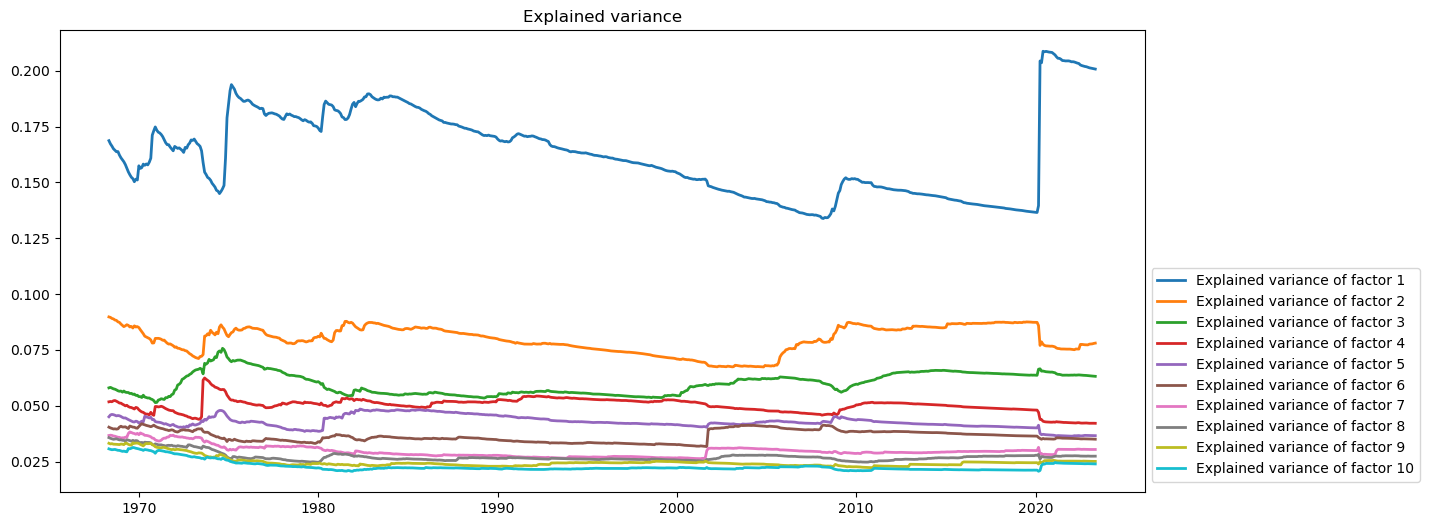

In [395]:
fix, ax = plt.subplots()

plt.title("Explained variance")

for i in range(cumsum_explained_variance_df.shape[1]):
    #ax.plot(cumsum_explained_variance_df.iloc[:, i], label = f"Sum of explained variance up til factor {i+1}", linewidth = 2)
    ax.plot(explained_variance_df.iloc[:, i], label = f"Explained variance of factor {i+1}", linewidth = 2)
    

plt.legend(loc = 'best', bbox_to_anchor=(1, 0.5))
plt.show()

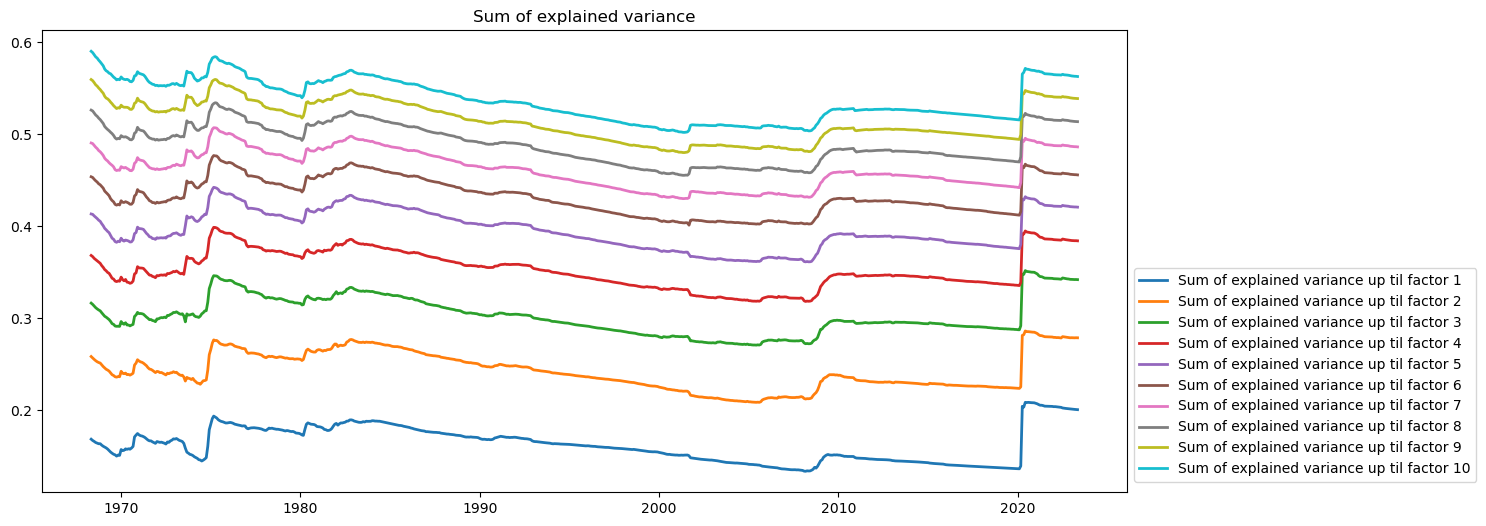

In [396]:
fix, ax = plt.subplots()

plt.title("Sum of explained variance")

for i in range(cumsum_explained_variance_df.shape[1]):
    ax.plot(cumsum_explained_variance_df.iloc[:, i], label = f"Sum of explained variance up til factor {i+1}", linewidth = 2)
    

plt.legend(loc = 'best', bbox_to_anchor=(1, 0.5))
plt.show()

Noticable: 
- Factors are quite stable, except for periods of increased uncertaintly (Covid-19, GFC, 70s);
- Half of the variance is consistently explained by less than 10 factors.

In [397]:
explanatory_power = {}

for i in data_normalised.columns:
    explanatory_power_for_each_input = {}
    for ii in range(principal_components.shape[1]):
        X = principal_components.iloc[:, :(ii + 1)].to_numpy()
        y = data_normalised[i].to_numpy()
        reg = LinearRegression().fit(X, y)
        explanatory_power_for_each_input[ii] = reg.score(X, y)
    
    explanatory_power[i] = explanatory_power_for_each_input 

In [398]:
explanatory_power_df = pd.DataFrame(explanatory_power)
incremental_explanatory_power = explanatory_power_df.copy()

for i in range(explanatory_power_df.shape[0] - 1, 0, -1):
    incremental_explanatory_power.iloc[i, :] = explanatory_power_df.iloc[i, :] - explanatory_power_df.iloc[i-1, :]
explanatory_power_df

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST
0,0.009709,0.246456,0.421205,0.447573,0.352732,0.754022,0.749543,0.683225,0.522492,0.567109,...,0.013347,0.005355,0.005678,0.005707,0.001928,0.000126,0.000042,0.000040,0.000961,0.001677
1,0.067071,0.292930,0.429665,0.447585,0.400127,0.763262,0.751132,0.684406,0.522627,0.567180,...,0.626594,0.035192,0.684571,0.043993,0.002154,0.002081,0.001086,0.000864,0.002346,0.003352
2,0.071249,0.302334,0.477795,0.482281,0.416337,0.794810,0.783348,0.729034,0.582948,0.649897,...,0.675249,0.035199,0.760544,0.044187,0.002718,0.002085,0.001272,0.001165,0.002361,0.003736
3,0.221804,0.347315,0.513375,0.517051,0.438917,0.799068,0.791774,0.736275,0.601011,0.664194,...,0.676106,0.035258,0.761762,0.044211,0.006628,0.002312,0.004698,0.008355,0.012392,0.003774
4,0.389149,0.369954,0.549739,0.523900,0.464536,0.830278,0.805661,0.746681,0.614457,0.668691,...,0.679836,0.046923,0.810230,0.066723,0.006901,0.003329,0.013530,0.014467,0.012444,0.007046
5,0.458017,0.372220,0.555541,0.528733,0.477303,0.845993,0.816308,0.758659,0.634309,0.671888,...,0.702297,0.052927,0.811187,0.098532,0.007452,0.005528,0.013566,0.036343,0.013302,0.020047
6,0.729064,0.468664,0.560207,0.530873,0.488635,0.850291,0.822268,0.765736,0.637671,0.677065,...,0.702498,0.055701,0.816778,0.109259,0.010660,0.005758,0.014574,0.063707,0.049672,0.034123
7,0.763741,0.474830,0.576980,0.535044,0.505662,0.855599,0.836737,0.785964,0.689944,0.715419,...,0.717295,0.055706,0.820226,0.126559,0.012997,0.007159,0.017523,0.079541,0.091455,0.039084
8,0.768806,0.481066,0.584668,0.535773,0.518694,0.875195,0.851387,0.801942,0.727120,0.727352,...,0.721571,0.056578,0.841034,0.132232,0.016348,0.016232,0.017791,0.081323,0.104585,0.059010
9,0.779413,0.481094,0.589952,0.539284,0.518772,0.914713,0.902842,0.872017,0.784594,0.741381,...,0.722830,0.056773,0.844100,0.151402,0.018958,0.018955,0.023777,0.092524,0.112070,0.076021


In [399]:
incremental_explanatory_power.mean(axis = 1)

0    0.183770
1    0.072833
2    0.064301
3    0.048305
4    0.040943
5    0.028382
6    0.033859
7    0.025847
8    0.026057
9    0.021445
dtype: float64

In [400]:
incremental_explanatory_power.index = [f"PC {i+1}" for i in range(n_components)]
incremental_explanatory_power.T.sort_values("PC 1", ascending=False)["PC 1"][:10]

PAYEMS       0.853176
IPMANSICS    0.796411
USGOOD       0.785996
INDPRO       0.754022
IPFPNSS      0.749543
MANEMP       0.740278
CUMFNS       0.736141
SRVPRD       0.713983
USTPU        0.702227
DMANEMP      0.692374
Name: PC 1, dtype: float64

In [401]:
incremental_explanatory_power.T.sort_values("PC 2", ascending=False)["PC 2"][:10]

CUSR0000SAC        0.714165
CUSR0000SA0L2      0.698745
DNDGRG3M086SBEA    0.678892
CPIAUCSL           0.674383
CUSR0000SA0L5      0.647175
PCEPI              0.613246
CPITRNSL           0.596821
CPIULFSL           0.562945
WPSFD49502         0.529144
WPSFD49207         0.506897
Name: PC 2, dtype: float64

In [402]:
incremental_explanatory_power.T.sort_values("PC 3", ascending=False)["PC 3"][:10]

HOUST       0.644036
PERMIT      0.613019
PERMITW     0.570538
HOUSTW      0.565755
HOUSTS      0.538934
PERMITMW    0.476195
HOUSTMW     0.435059
PERMITNE    0.398631
PERMITS     0.393039
HOUSTNE     0.335831
Name: PC 3, dtype: float64

In [403]:
incremental_explanatory_power.T.sort_values("PC 4", ascending=False)["PC 4"][:10]

S&P div yield    0.325399
S&P PE ratio     0.293775
S&P 500          0.273031
S&P: indust      0.267274
BAA              0.241795
T5YFFM           0.229129
AAAFFM           0.224854
T10YFFM          0.221277
BAAFFM           0.219108
M2REAL           0.189596
Name: PC 4, dtype: float64

In [404]:
incremental_explanatory_power.T.sort_values("PC 5", ascending=False)["PC 5"][:10]

GS1         0.199253
CP3Mx       0.178314
TB6MS       0.178061
GS5         0.172603
RPI         0.167345
AAA         0.165060
TB6SMFFM    0.164753
BAA         0.162165
TB3SMFFM    0.160458
T1YFFM      0.155579
Name: PC 5, dtype: float64

In [405]:
incremental_explanatory_power.T.sort_values("PC 6", ascending=False)["PC 6"][:10]

M1SL         0.393790
M2SL         0.263792
TOTRESNS     0.217300
NONBORRES    0.151695
TB6MS        0.145072
TB3MS        0.143822
GS1          0.142855
GS5          0.141049
GS10         0.120594
CONSPI       0.098700
Name: PC 6, dtype: float64

The results are similar to what has been shown in https://s3.amazonaws.com/real.stlouisfed.org/wp/2015/2015-012.pdf both in terms of groups identified based on factor loadings approximated using incremental change in the coefficient of determination as more factors are added and in terms of the average loadings of factors. Important to note that this approach ignores lead-lag structure within the data corresponding to the same area of economic activity, i.e. leading, coincident and lagging indicators are most probably explained by different factors in such decomposition. To overcome such limitation we might be more interested in using only leading and/or coincident indicators and extract principal components from them in order to have a better overview of underlying forces within leading economic signals.

## Pipeline 

For model training and validation we have the following pipeline:
- We skip initial n years of data (baseline = 5 years) for applying standardization and other transformations;
- We treat the last k years of data as our test subset (depending on the number of months ahead forecasting the actual value changes, but in all scenarios we treat data starting at least from 2011 as test subset);
- Within the remaining data, we create subsets of l + m months (l = 360, m = 60 in baseline scenario) as training and testing subsets and slide over the data with a step of 12 months to generate multiple instances of training/testing subsets. As a result we train out model always on l months of data and evaluate its performance on m months of data. Though we have overlaps between the different train/test subsets (as a step of 12 months is less than m), this helps us facilitate multiple folds and keep the folds equal weighted for the final evaluation (since in all cases we have the same number of samples for training and evaluation).

The design of our tests is to evaluate a selection of models while changing:
- forecast horizon (1, 3, 6, 12, 24)
- lags included:  [1], [1..3], [1..6], [12], [12, 24], [12, 24, 36], [12, 24, 36, 48], [12, 24, 36, 48], [12, 24, 36, 48, 60]
- applying standardization vs. not applying it
- extracting principal components or not
- converting to a classification problem (US recessions)

In [406]:
class Pipeline:

    def __init__(self, 
                 df,
                 y_name,
                 model,
                 autoregressive_lags, 
                 lags, 
                 h_ahead, 
                 start_rolling_std="1965-01-01", 
                 standardize=True,
                 use_pca=False, 
                 num_components=20, 
                 latest_start_test="2003-07-01", 
                 size_train=360, 
                 size_val=60, 
                 step=12,
                 metric=mean_absolute_error,
                 one_val_fold=False):
        
        """
        df: pd.Dataframe with X and y
        y_name: str, column name of the target variable
        autoregressive_lags: list with the lags of the target variable
        lags: list with lags (as integers)
        h_ahead: int (how many month ahead do we make a forecast)
        start_rolling_std: str, date until which the data is used to kick start the transformations for standardization and PCA
        standardize: boolean
        use_pca: boolean 
        num_components: int, the number of components to extract during PCA 
        """

        self.data = df.copy()
        self.y_name = y_name
        self.model = model
        self.autoregressive_lags = autoregressive_lags 
        self.lags = lags 
        self.h_ahead = h_ahead
        self.start_rolling_std = start_rolling_std
        self.standardize = standardize
        self.use_pca = use_pca
        self.num_components = num_components

        self.latest_start_test = latest_start_test
        self.size_train = size_train
        self.size_val = size_val
        self.step = step
        self.one_val_fold = one_val_fold

        self.metric = metric


    def prepare_data(self):
        
        y = self.data[self.y_name].copy()
        del self.data[self.y_name]

        iloc_start_rolling_std = self.data.index.get_loc(self.start_rolling_std)

        if self.standardize:
        
            scaler = StandardScaler()
            X_normalized = pd.DataFrame(scaler.fit_transform(self.data.iloc[:iloc_start_rolling_std]), index=self.data.index[:iloc_start_rolling_std], columns=self.data.columns)

            if self.use_pca:
                pca = PCA(n_components=self.num_components)
                pca.fit(X_normalized) 
                X_normalized = pd.DataFrame(pca.transform(X_normalized), index=self.data.index[:iloc_start_rolling_std], columns=[f"{i} PC" for i in range(self.num_components)])

            for i in range(iloc_start_rolling_std+1, len(self.data)+1):
                X_normalized_new = pd.DataFrame(scaler.fit_transform(self.data.iloc[:i]), index=self.data.index[:i], columns=self.data.columns)
            
                if self.use_pca:
                    X_normalized_new = pd.DataFrame(pca.transform(X_normalized_new), index=self.data.index[:i], columns=[f"{i} PC" for i in range(self.num_components)])

                X_normalized = pd.concat([X_normalized.T, X_normalized_new.iloc[-1]], axis=1).T
    
        else:
            X_normalized = self.data

        if self.standardize:

            scaler_y = StandardScaler()
            y_normalized = scaler_y.fit_transform(y.iloc[:iloc_start_rolling_std].to_numpy().reshape(-1,1))

            for i in range(iloc_start_rolling_std+1, len(self.data)+1):
                y_normalized_new = scaler_y.fit_transform(y.iloc[:i].to_numpy().reshape(-1,1))
                y_normalized = np.append(y_normalized, y_normalized_new[-1])
            
            y_normalized_s = pd.Series(y_normalized, index=y.index)
    
        else:
            y_normalized_s = y

        for c in X_normalized.columns:
            for l in self.lags:
                name = f"{c}, {l}-month lag"
                new = X_normalized[c].shift(l)
                new.name = name
            
                X_normalized = pd.concat([X_normalized, new], axis=1)

        for l in self.autoregressive_lags:
            name = f"{self.y_name}, {l}-month lag"
            new = y_normalized_s.shift(l)
            new.name = name
            X_normalized = pd.concat([X_normalized, new], axis=1)

        if self.h_ahead == 0:
            y_shifted = y
        else:
            y_shifted = y.shift(-self.h_ahead)

        if len(self.lags) > 0:

            if self.h_ahead == 0:
                y = y_shifted
                X = X_normalized
            else:
                y = y_shifted.iloc[max(self.lags):-self.h_ahead]
                X = X_normalized.iloc[max(self.lags):-self.h_ahead]

        else:
            if self.h_ahead == 0:
                y = y_shifted
                X = X_normalized
                
            else:
                y = y_shifted.iloc[:-self.h_ahead]
                X = X_normalized.iloc[:-self.h_ahead]

        assert (y.index == X.index).all()
        
        self.y = y
        self.X = X
        self.skip = iloc_start_rolling_std


    def generate_train_val_samples(self):

        train_val = []
        iloc_start_test = self.y.index.get_loc(self.latest_start_test)
        

        rw_errors = []

        if self.one_val_fold:
            self.size_train = len(self.y) - self.skip - (len(self.y) - iloc_start_test) - self.size_val

            train_val.append((self.y.iloc[(self.skip):(self.skip+self.size_train)], self.X.iloc[(self.skip):(self.skip+self.size_train)], self.y.iloc[(self.skip+self.size_train):iloc_start_test], self.X.iloc[(self.skip+self.size_train):iloc_start_test]))
            rw_errors.append(self.metric(y_pred=self.y.iloc[(self.skip+self.size_train - self.h_ahead):(iloc_start_test - self.h_ahead)], y_true=self.y.iloc[(self.skip+self.size_train):iloc_start_test]))

        else:
            for i in range(self.skip + self.size_train + self.size_val, iloc_start_test, self.step):

                train_val.append((self.y.iloc[(i - self.size_train - self.size_val):(i - self.size_val)], self.X.iloc[(i - self.size_train - self.size_val):(i - self.size_val)], self.y.iloc[(i - self.size_val):i], self.X.iloc[(i - self.size_val):i]))
                rw_errors.append(self.metric(y_pred=self.y.iloc[(i - self.size_val - self.h_ahead):(i - self.h_ahead)], y_true=self.y.iloc[(i - self.size_val):i]))
        
        self.full_train_sample = (self.y.iloc[self.skip:iloc_start_test], self.X.iloc[self.skip:iloc_start_test])
        self.test_sample = (self.y.iloc[iloc_start_test:], self.X.iloc[iloc_start_test:])
        self.test_rw_prediction = self.y.shift(self.h_ahead).iloc[iloc_start_test:]
        self.train_val = train_val
        self.rw_errors = rw_errors
        
    
    def train_validate_model(self):

        errors = []

        for y_train, X_train, y_test, X_test in self.train_val:
            
            self.model.fit(X_train, y_train)
            prediction = self.model.predict(X_test)
            error = self.metric(y_pred=prediction, y_true=y_test)
            errors.append(error)

        self.errors = errors

    def test_model(self):

        self.model.fit(X=self.full_train_sample[1], y=self.full_train_sample[0])
        self.prediction = pd.Series(self.model.predict(self.test_sample[1]), index=self.test_sample[0].index)
        self.test_error = self.metric(y_pred=self.prediction, y_true=self.test_sample[0])

## Identification of a problem

In [407]:
def has_consecutive_negatives(window):
    return int((window < 0).sum() >= 6)

consecutive_negative_growth_before = data["INDPRO"].rolling(window=6).apply(has_consecutive_negatives, raw=True).fillna(0)
consecutive_negative_growth_after = data["INDPRO"][::-1].rolling(window=6).apply(has_consecutive_negatives, raw=True).fillna(0)[::-1]

def func(series):
    return series > 0

technical_recession = (consecutive_negative_growth_before + consecutive_negative_growth_after).apply(func)

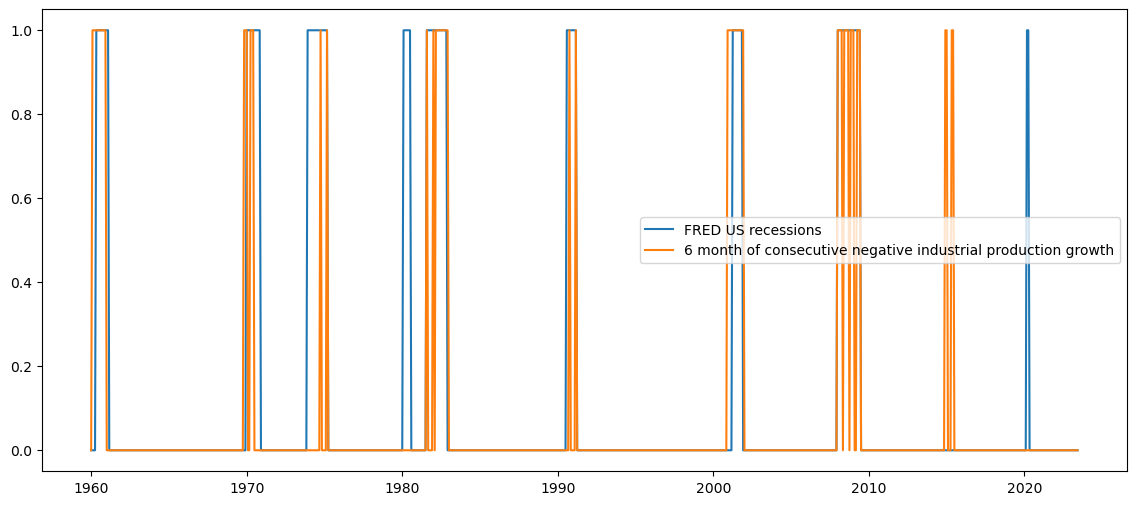

In [408]:
fix, ax = plt.subplots()

ax.plot(us_recession, label="FRED US recessions")
ax.plot(technical_recession, label="6 month of consecutive negative industrial production growth")

plt.legend(loc="best")
plt.show()

In [409]:
unrate_yoy = df["UNRATE"].iloc[1:].diff(12)
unrate_yoy.index = df["sasdate"][1:]
unrate_yoy.index = pd.to_datetime(unrate_yoy.index)

data_with_unrate_yoy = data.copy()
data_with_unrate_yoy["UNRATE"] = unrate_yoy

In [410]:
indpro_yoy = np.log(df["INDPRO"].iloc[1:]).diff(12) * 100
indpro_yoy.index = df["sasdate"][1:]
indpro_yoy.index = pd.to_datetime(indpro_yoy.index)

indpro_mom = np.log(df["INDPRO"].iloc[1:]).diff(1) * 100
indpro_mom.index = df["sasdate"][1:]
indpro_mom.index = pd.to_datetime(indpro_mom.index)


regions = []
current_region = None

for i, value in enumerate(us_recession.to_numpy()):
    if value == 1:
        if current_region is None:
            current_region = [i, i]
        else:
            current_region[1] = i
    else:
        if current_region is not None:
            regions.append(current_region)
            current_region = None

if current_region is not None:
    regions.append(current_region)

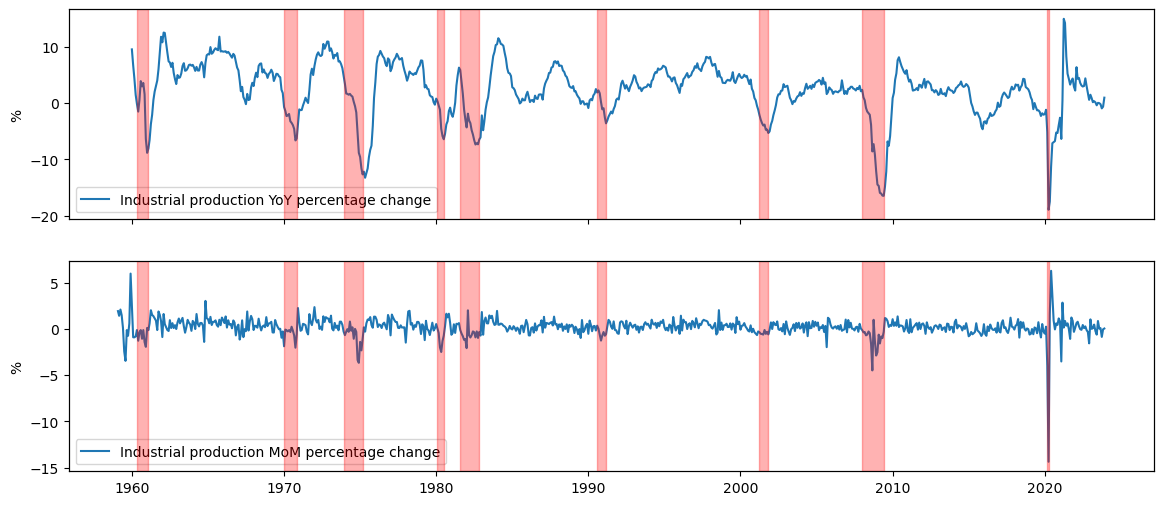

In [411]:
fig, axs = plt.subplots(2, sharex=True)

axs[0].plot(indpro_yoy, label = 'Industrial production YoY percentage change')
axs[0].set_ylabel('%')

ax0_r = axs[0].twinx()
ax0_r.set_ylim(0, 1)
ax0_r.yaxis.set_visible(False)

for start, end in regions:
    if int(us_recession.iloc[start]) == 1:
        ax0_r.axvspan(us_recession.index[start], us_recession.index[end], color='red', alpha=0.3)
    else:
        ax0_r.axvspan(us_recession.index[start], us_recession.index[end], color='blue', alpha=0.3)

axs[1].plot(indpro_mom, label = 'Industrial production MoM percentage change')
axs[1].set_ylabel('%')

ax1_r = axs[1].twinx()
ax1_r.set_ylim(0, 1)
ax1_r.yaxis.set_visible(False)

for start, end in regions:
    if int(us_recession.iloc[start]) == 1:
        ax1_r.axvspan(us_recession.index[start], us_recession.index[end], color='red', alpha=0.3)
    else:
        ax1_r.axvspan(us_recession.index[start], us_recession.index[end], color='blue', alpha=0.3)


axs[0].legend()
axs[1].legend()

plt.show()

In [412]:
data_with_indpro_yoy = data.copy()
data_with_indpro_yoy["INDPRO"] = indpro_yoy
data_with_indpro_yoy["INDPRO"]

data_with_indpro_mom = data.copy()
data_with_indpro_mom["INDPRO"] = data_with_indpro_mom["INDPRO"] * 100

## Regression problem

Regression models:
- Ridge
- Lasso
- LassoLars
- SVR
- RandomForest Regressor
- MLPRegressor
- GradientBoosting Regressor

Baseline scenario:
- Use YoY change in industrial production
- Use only the original data and 1-month lagged data
- 12-month ahead forecast
- Standardized data

In [413]:
h_s = [1, 3, 6, 12, 24]
lags_s = [[1], [1,2,3], [12], [12, 24], [12, 24, 36]]

### Testing individual models

In [91]:
alphas_ridge_lasso = [10 ** (-5  + (i * 9 / 99)) for i in range(0, 100)]

#### Ridge 

In [97]:
model_ridge = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=Ridge(alpha=alphas_ridge_lasso[0]),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_ridge.prepare_data()
model_ridge.generate_train_val_samples()

mae_ridge = {}

for a in alphas_ridge_lasso:

    model_ridge.model = Ridge(alpha=a)
    model_ridge.train_validate_model()
    mae_ridge[a] = model_ridge.errors 

mean_mae_ridge = [np.asarray(i).mean() for i in mae_ridge.values()]

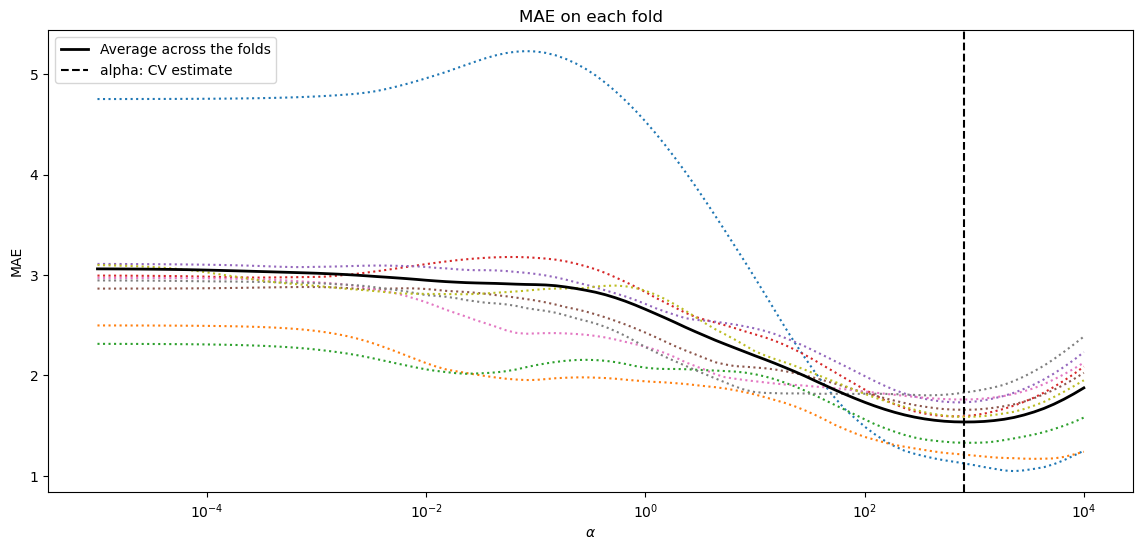

In [106]:
plt.semilogx(alphas_ridge_lasso, mae_ridge.values(), linestyle=":")

plt.plot(alphas_ridge_lasso, mean_mae_ridge,
    color="black", label="Average across the folds", linewidth=2)

plt.axvline(alphas_ridge_lasso[np.argmin(mean_mae_ridge)], linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("MAE")
plt.legend()
plt.title(f"MAE on each fold")
plt.show()

In [107]:
model_ridge = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=Ridge(alpha=alphas_ridge_lasso[np.argmin(mean_mae_ridge)]),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_ridge.prepare_data()
model_ridge.generate_train_val_samples()
model_ridge.train_validate_model()
np.mean(model_ridge.errors)

1.5359133072629823

In [108]:
np.mean(model_ridge.rw_errors)

1.6693726963334545

#### Lasso

In [109]:
model_lasso = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=Lasso(alpha=alphas_ridge_lasso[0], max_iter=100000),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_lasso.prepare_data()
model_lasso.generate_train_val_samples()

mae_lasso = {}

for a in alphas_ridge_lasso:

    model_lasso.model = Lasso(alpha=a)
    model_lasso.train_validate_model()
    mae_lasso[a] = model_lasso.errors 

mean_mae_lasso = [np.asarray(i).mean() for i in mae_lasso.values()]

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e+02, tolerance: 7.751e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e+02, tolerance: 7.406e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e+02, tolerance: 7.282e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e+02, tolerance: 7.212e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.444e+02, tolerance: 7.144e-01
Objective did n

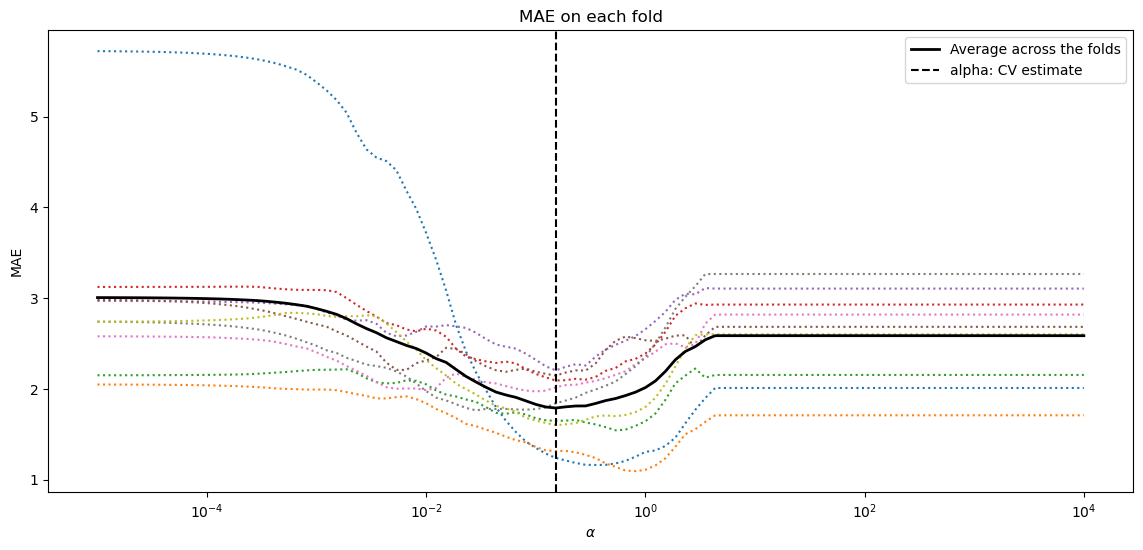

In [110]:
plt.semilogx(alphas_ridge_lasso, mae_lasso.values(), linestyle=":")

plt.plot(alphas_ridge_lasso, mean_mae_lasso,
    color="black", label="Average across the folds", linewidth=2)

plt.axvline(alphas_ridge_lasso[np.argmin(mean_mae_lasso)], linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("MAE")
plt.legend()
plt.title(f"MAE on each fold")
plt.show()

In [111]:
model_lasso = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=Lasso(alpha=alphas_ridge_lasso[np.argmin(mean_mae_lasso)]),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 #use_pca=True
                 )
model_lasso.prepare_data()
model_lasso.generate_train_val_samples()
model_lasso.train_validate_model()
np.mean(model_lasso.errors)

1.7893523654666472

In [112]:
np.mean(model_lasso.rw_errors)

1.6693726963334545

#### Lasso LARS

In [113]:
model_lars = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=linear_model.LassoLars(alpha=alphas_ridge_lasso[0]),
                 lags=[],#lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_lars.prepare_data()
model_lars.generate_train_val_samples()

mae_lars = {}

for a in alphas_ridge_lasso:

    model_lars.model = linear_model.LassoLars(alpha=a)
    model_lars.train_validate_model()
    mae_lars[a] = model_lars.errors 

mean_mae_lars= [np.asarray(i).mean() for i in mae_lars.values()]

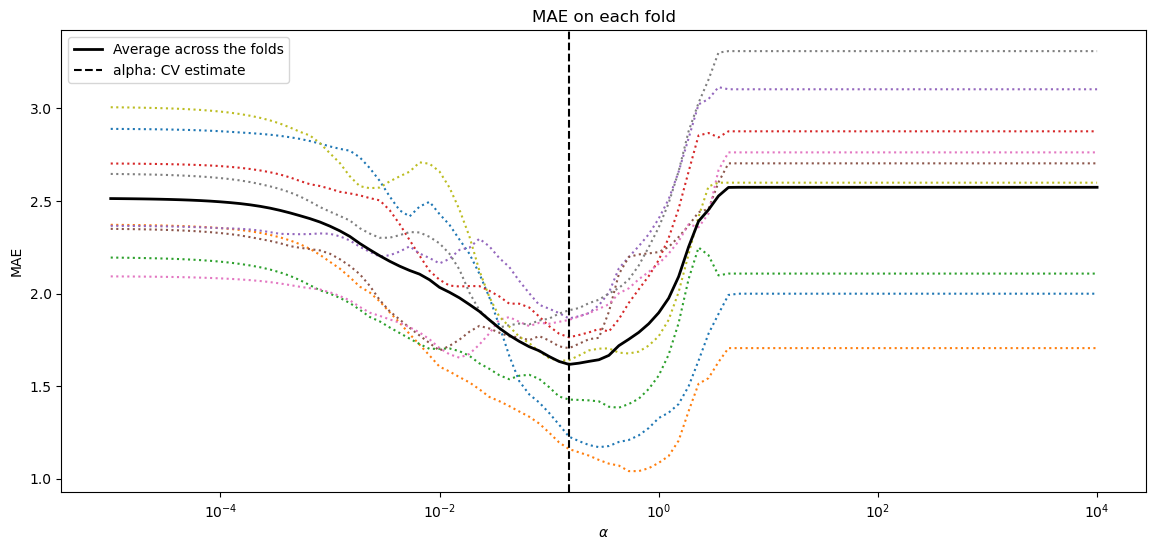

In [114]:
plt.semilogx(alphas_ridge_lasso, mae_lars.values(), linestyle=":")

plt.plot(alphas_ridge_lasso, mean_mae_lars,
    color="black", label="Average across the folds", linewidth=2)

plt.axvline(alphas_ridge_lasso[np.argmin(mean_mae_lars)], linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("MAE")
plt.legend()
plt.title(f"MAE on each fold")
plt.show()

In [115]:
alphas_ridge_lasso[np.argmin(mean_mae_lars)]

0.1519911082952933

In [116]:
alphas_ridge_lasso[np.argmin(mean_mae_lasso)]

0.1519911082952933

#### SVR

In [55]:
C = [2 ** (1  + (i * 4 / 9)) for i in range(0, 10)]
gamma = [2 ** (-7  + (i * 6 / 9)) for i in range(0, 10)]
epsilon = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [121]:
model_svr = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=SVR(C=2, gamma=gamma[0], epsilon=epsilon[0]),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_svr.prepare_data()
model_svr.generate_train_val_samples()

mae_svr = {}

for g in gamma:
    for eps in epsilon:

        model_svr.model = SVR(C=2, gamma=g, epsilon=eps)
        model_svr.train_validate_model()
        mae_svr[f"{g},{eps}"] = model_svr.errors 

mean_mae_svr = [np.asarray(i).mean() for i in mae_svr.values()]

In [122]:
mean_mae_svr_dict = {k: np.asarray(v).mean() for (k,v) in mae_svr.items()}

In [123]:
mean_mae_svr_arr = np.zeros((len(gamma), len(epsilon)))

In [124]:
for k,v in mean_mae_svr_dict.items():
    els = [float(i) for i in k.split(',')]
    for ii, g in enumerate(gamma):
        if g == els[0]:
            for iii, e in enumerate(epsilon):
                if e == els[1]:
                    mean_mae_svr_arr[ii, iii] = v

In [125]:
list(mae_svr.keys())[np.argmin(mean_mae_svr)]

'0.0078125,0.5'

In [126]:
np.min(mean_mae_svr)

1.7024147150415248

In [127]:
np.min(mean_mae_svr_arr)

1.7024147150415248

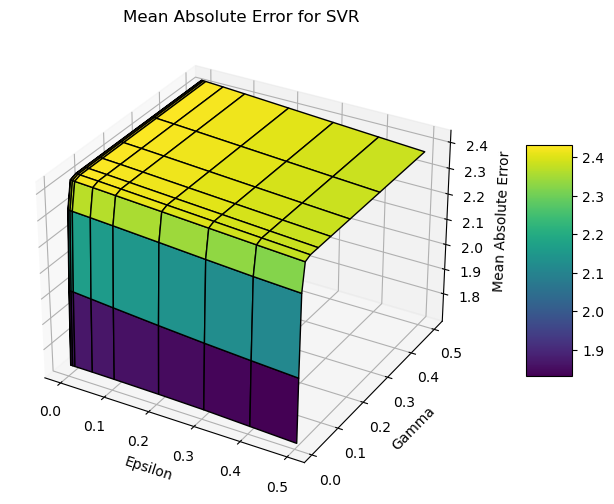

In [128]:
# Plot 3D surface

E, G = np.meshgrid(epsilon, gamma)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(E,G, Z=mean_mae_svr_arr[:,:], cmap='viridis', edgecolor='k')

# Set labels and title
ax.set_xlabel('Epsilon')
ax.set_ylabel('Gamma')
ax.set_zlabel('Mean Absolute Error')
plt.title('Mean Absolute Error for SVR')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

#### Random Forest Regressor

In [133]:
max_depth_s = [2, 3, 5, 8, 10, 30]
max_features_s = [3, 5, 7, 11, 30]

In [134]:
model_rf = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=RandomForestRegressor(n_estimators=500, 
                                             criterion="absolute_error"),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_rf.prepare_data()
model_rf.generate_train_val_samples()

mae_rf = {}

count = 0
for i in max_depth_s:
    for ii in max_features_s:
        model_rf.model = RandomForestRegressor(n_estimators=500, 
                                             max_depth=i,
                                             max_features=ii)
        model_rf.train_validate_model()
        mae_rf[f"{i},{ii}"] = model_rf.errors
        count+=1
        if count % 10 == 0:
            print(count)


mean_mae_rf = [np.asarray(i).mean() for i in mae_rf.values()]

10
20
30


In [140]:
np.min(mean_mae_rf)

1.68325615848618

In [141]:
list(mae_rf.keys())[np.argmin(mean_mae_rf)]

'10,3'

#### Gradient boosting

In [35]:
subsample = [0.05, .1, .3, .6, .9]
n_estimators = [5, 10, 30, 75]
max_depth = [2, 5, 8, 15]

In [43]:
model_gbr = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=GradientBoostingRegressor(subsample=subsample[0], 
                                     n_estimators=n_estimators[1],
                                     loss='absolute_error', 
                                     max_depth=max_depth[1],
                                     random_state=92834),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_gbr.prepare_data()
model_gbr.generate_train_val_samples()
model_gbr.train_validate_model()

In [44]:
np.mean(model_gbr.errors)

2.0356732806514954

#### MLP Regressor

In [45]:
solver = "lbfgs"
max_iter = 2000
hidden_layer_sizes = [5, (5,5), (5,5,5), 10, (10,10), (10,10,10), 15,
                      (15, 15), 25, (25, 25), (25, 25, 25)]
activation = ["relu", "tanh"]
alpha = [10 ** i for i in range(-5, 4)]

In [76]:
model_mlp = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=MLPRegressor(solver=solver, 
                                    max_iter=max_iter, 
                                    hidden_layer_sizes=hidden_layer_sizes[-1],
                                    activation=activation[0],
                                    alpha=alpha[-4]),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True,
                 step=12
                 )
model_mlp.prepare_data()
model_mlp.generate_train_val_samples()
model_mlp.size_train

360

In [77]:
model_mlp.train_validate_model()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


In [78]:
model_mlp.errors

[1.653732491380271, 1.8986192807173192, 2.0079222961328616, 2.2588999468504847]

In [79]:
np.mean(model_mlp.errors)

1.9547935037702342

In [80]:
model_mlp.test_model()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


In [83]:
model_mlp.test_error

3.9483129953582266

In [81]:
p = pd.Series(model_mlp.prediction, index=model_mlp.test_sample[0].index)

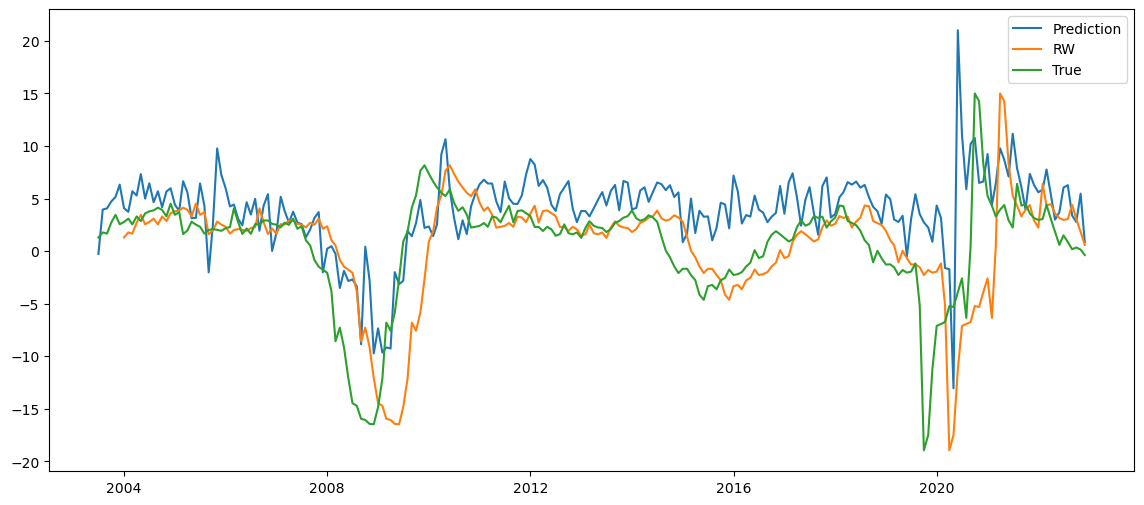

In [82]:
fix, ax = plt.subplots()

ax.plot(p, label="Prediction")
ax.plot(model_mlp.test_sample[0].shift(6), label="RW")
ax.plot(model_mlp.test_sample[0], label="True")

plt.legend(loc="best")
plt.show()

In [578]:
"""
explainer = shap.Explainer(gbr)
shap_values = explainer.shap_values(X_test[7])
shap.initjs()

shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = X_df.columns
)
"""

'\nexplainer = shap.Explainer(gbr)\nshap_values = explainer.shap_values(X_test[7])\nshap.initjs()\n\nshap.force_plot(\n    base_value = explainer.expected_value,\n    shap_values = shap_values,\n    features = X_df.columns\n)\n'

### Joint testing of the models

In [32]:
def evaluate_models(df=data_with_indpro_yoy,
                 y_name=target_variable,
                 autoregressive_lags=None, 
                 lags=None, 
                 h_ahead=None, 
                 start_rolling_std="1965-01-01", 
                 standardize=True,
                 use_pca=False, 
                 num_components=10, 
                 latest_start_test="2003-07-01", 
                 size_train=360, 
                 size_val=60, 
                 step=12,
                 random_state=98234):
    
    pipeline = Pipeline(df=df,
                 y_name=y_name,
                 autoregressive_lags=autoregressive_lags, 
                 model=None,
                 lags=lags, 
                 h_ahead=h_ahead, 
                 start_rolling_std=start_rolling_std, 
                 standardize=standardize,
                 use_pca=use_pca, 
                 num_components=num_components, 
                 latest_start_test=latest_start_test, 
                 size_train=size_train, 
                 size_val=size_val, 
                 step=step)
    
    
    
    pipeline.prepare_data()
    pipeline.generate_train_val_samples()

    
    print("Ridge")
    print("-"*50)

    alphas_ridge = [10 ** (-5  + (i * 9 / 99)) for i in range(0, 100)]

    mae_ridge = {}
    for a in alphas_ridge:
        pipeline.model = Ridge(alpha=a, random_state=random_state) 
        pipeline.train_validate_model()
        mae_ridge[a] = pipeline.errors 

    mean_mae_ridge = [np.asarray(i).mean() for i in mae_ridge.values()]
    
    pipeline.model = Ridge(alpha=alphas_ridge[np.argmin(mean_mae_ridge)], random_state=random_state)
    pipeline.test_model()

    print(f"Ridge: {np.round(pipeline.test_error, 2)}")
    print(f"Alpha: {alphas_ridge[np.argmin(mean_mae_ridge)]}")
    print("-"*50)
    ridge_summary = [mae_ridge, mean_mae_ridge, pipeline.prediction]


    print("LassoLARS")
    print("-"*50)

    alphas_lasso = [10 ** (-5  + (i * 9 / 99)) for i in range(0, 100)]

    mae_lasso = {}
    for a in alphas_lasso:
        pipeline.model = linear_model.LassoLars(alpha=a, random_state=random_state)
        pipeline.train_validate_model()
        mae_lasso[a] = pipeline.errors 

    mean_mae_lasso = [np.asarray(i).mean() for i in mae_lasso.values()]
    
    pipeline.model = linear_model.LassoLars(alpha=alphas_lasso[np.argmin(mean_mae_lasso)], random_state=random_state)
    pipeline.test_model()

    print(f"LassoLARS: {np.round(pipeline.test_error, 2)}")
    print(f"Alpha: {alphas_lasso[np.argmin(mean_mae_lasso)]}")
    print("-"*50)
    lasso_summary = [mae_lasso, mean_mae_lasso, pipeline.prediction]

    
    print("SVR")
    print("-"*50)

    C = [2 ** (1  + (i * 4 / 9)) for i in range(0, 10, 2)]
    gamma = [2 ** (-7  + (i * 6 / 9)) for i in range(0, 10, 2)]
    epsilon = [0.0001, 0.01, 0.05, 0.1, 0.3, 0.5]

    mae_svr = {}
    for c in C:
        for g in gamma:
            for eps in epsilon:
                pipeline.model = SVR(C=c, gamma=g, epsilon=eps)
                pipeline.train_validate_model()
                mae_svr[f"{c}, {g}, {eps}"] = pipeline.errors 

    mean_mae_svr = [np.asarray(i).mean() for i in mae_svr.values()]

    c, g, eps = (float(i) for i in list(mae_svr.keys())[np.argmin(mean_mae_svr)].split(","))
    
    pipeline.model = SVR(C=c, gamma=g, epsilon=eps)
    pipeline.test_model()

    print(f"SVR: {np.round(pipeline.test_error, 2)}")
    print(f"C: {c}, G: {g}, eps: {eps}")
    print("-"*50)
    svr_summary = [mae_svr, mean_mae_svr, pipeline.prediction]

    
    print("RandomForestRegressor")
    print("-"*50)

    max_depth_rf = [2, 3, 5, 8, 10, 30, 50]
    max_features_s = [3, 5, 7, 11, 30, 50]

    mae_rf = {}
    for max_d in max_depth_rf:
        for max_f in max_features_s:
            pipeline.model = RandomForestRegressor(n_estimators=500, 
                                                   max_depth=max_d,
                                                   max_features=max_f,
                                                   random_state=random_state)
            pipeline.train_validate_model()
            mae_rf[f"{max_d}, {max_f}"] = pipeline.errors 

    mean_mae_rf = [np.asarray(i).mean() for i in mae_rf.values()]

    max_d, max_f = (int(i) for i in list(mae_rf.keys())[np.argmin(mean_mae_rf)].split(","))
    
    pipeline.model = RandomForestRegressor(n_estimators=500, 
                                           max_depth=max_d,
                                           max_features=max_f,
                                           random_state=random_state)
    pipeline.test_model()

    print(f"RandomForestRegressor: {np.round(pipeline.test_error, 2)}")
    print(f"Max depth: {max_d}, Max features: {max_f}")
    print("-"*50)
    rf_summary = [mae_rf, mean_mae_rf, pipeline.prediction]

    
    print("GradientBoostingRegressor")
    print("-"*50)

    subsample = [0.05, .1, .3, .6, .9]
    n_estimators = [5, 10, 30, 75, 150]
    max_depth_gb = [2, 5, 8, 15]

    mae_gbr = {}
    for subs in subsample:
        for n_est in n_estimators:
            for md_gb in max_depth_gb:
                pipeline.model = GradientBoostingRegressor(subsample=subs, 
                                     n_estimators=n_est,
                                     loss='absolute_error', 
                                     max_depth=md_gb,
                                     random_state=random_state)
                pipeline.train_validate_model()
                mae_gbr[f"{subs}, {n_est}, {md_gb}"] = pipeline.errors 

    mean_mae_gbr = [np.asarray(i).mean() for i in mae_gbr.values()]

    params_gbr = list(mae_gbr.keys())[np.argmin(mean_mae_gbr)].split(",")
    subs, n_est, md_gb = float(params_gbr[0]), int(params_gbr[1]), int(params_gbr[2])
    
    pipeline.model = GradientBoostingRegressor(subsample=subs, 
                                     n_estimators=n_est,
                                     loss='absolute_error', 
                                     max_depth=md_gb,
                                     random_state=random_state)
    pipeline.test_model()

    print(f"GradientBoostingRegressor: {np.round(pipeline.test_error, 2)}")
    print(f"Subsample: {subs}, n estimators: {n_est}, Max depth: {md_gb}")
    print("-"*50)
    gbr_summary = [mae_gbr, mean_mae_gbr, pipeline.prediction]


    print("MLPRegressor")
    print("-"*50)

    solver = "lbfgs"
    max_iter = 10000
    hidden_layer_sizes = [5, (5,5), 10, (10,10)]
    alpha = [10 ** i for i in range(-5, 4, 2)]

    mae_mlp = {}
    for hl in hidden_layer_sizes:
        for a in alpha:
            pipeline.model = MLPRegressor(solver=solver, 
                                    max_iter=max_iter, 
                                    hidden_layer_sizes=hl,
                                    activation="relu",
                                    alpha=a,
                                    random_state=random_state)
            pipeline.train_validate_model()
            mae_mlp[f"{hl}; {a}"] = pipeline.errors 

    mean_mae_mlp = [np.asarray(i).mean() for i in mae_mlp.values()]

    params_mlp = list(mae_mlp.keys())[np.argmin(mean_mae_mlp)].split(";")
    
    a = float(params_mlp[1])
    if params_mlp[0].startswith("("):
        hl = tuple([int(i) for i in params_mlp[0][1:-1].split(",")])
    else:
        hl = int(params_mlp[0])
    
    pipeline.model = MLPRegressor(solver=solver, 
                                    max_iter=max_iter, 
                                    hidden_layer_sizes=hl,
                                    activation="relu",
                                    alpha=a,
                                    random_state=random_state)
    pipeline.test_model()

    
    print(f"MLPRegressor: {np.round(pipeline.test_error, 2)}")
    print(f"Hidden layer sizes: {hl}, alpha: {a}")
    print("-"*50)
    mlp_summary = [mae_mlp, mean_mae_mlp, pipeline.prediction]

    print(f"RW: {np.round(mean_absolute_error(y_pred=pipeline.test_rw_prediction, y_true=pipeline.test_sample[0]), 2)}")
    print("-"*50)
    
    
    return ridge_summary, lasso_summary, svr_summary, rf_summary, gbr_summary, mlp_summary, pipeline

In [69]:
r, l, svr, rf, gbr, mlp, p = evaluate_models(df=data_with_indpro_yoy,
                       y_name=target_variable, 
                       autoregressive_lags=[0] + lags_s[0], 
                       lags=lags_s[0],
                       h_ahead=6,
                       standardize=True)

Ridge
--------------------------------------------------
Ridge: 3.54
Alpha: 657.9332246575682
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 3.63
Alpha: 0.018738174228603847
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 3.35
C: 12.699208415745595, G: 0.0078125, eps: 0.5
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 3.48
Max depth: 10, Max features: 30
--------------------------------------------------
GradientBoostingRegressor
--------------------------------------------------
GradientBoostingRegressor: 3.57
Subsample: 0.3, n estimators: 75, Max depth: 8
--------------------------------------------------
MLPRegressor
--------------------------------------------------
MLPRegressor: 3.43
Hidden layer sizes: 10, alpha: 1000.0
-------------------------

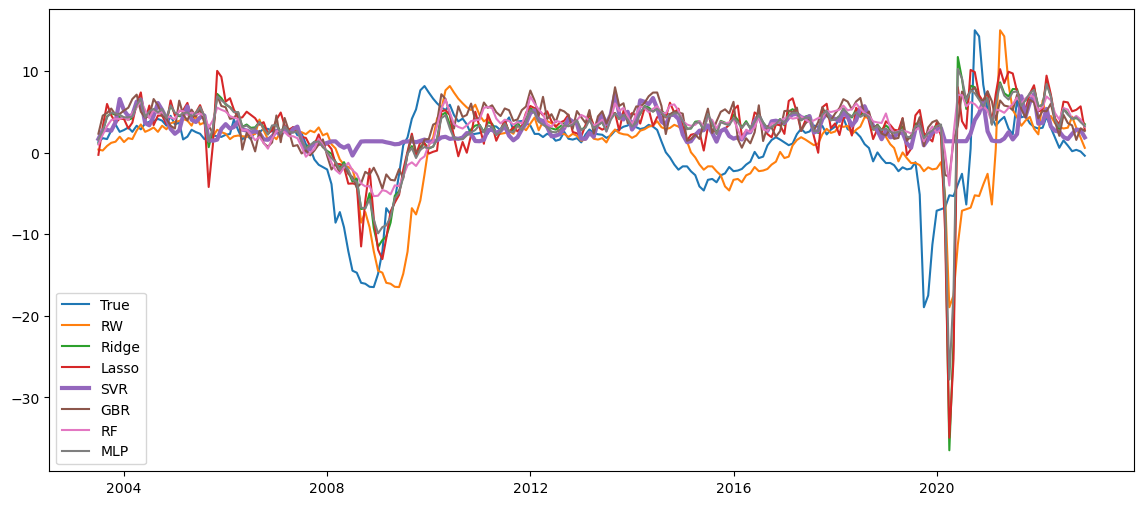

In [72]:
fix, ax = plt.subplots()

ax.plot(p.test_sample[0], label="True")
ax.plot(p.test_rw_prediction, label="RW")
ax.plot(r[2], label="Ridge")
ax.plot(l[2], label="Lasso")
ax.plot(svr[2], label="SVR", linewidth=3)
ax.plot(gbr[2], label="GBR")
ax.plot(rf[2], label="RF")
ax.plot(mlp[2], label="MLP")

plt.legend(loc="best")
plt.show()

### Choosing forecast horizon

In [43]:
r_h0, l_h0, svr_h0, rf_h0, gbr_h0, mlp_h0, p_h0 = evaluate_models(df=data_with_indpro_yoy,
                       y_name=target_variable, 
                       autoregressive_lags=[0] + lags_s[0], 
                       lags=lags_s[0],
                       h_ahead=h_s[0],
                       standardize=True)

Ridge
--------------------------------------------------
Ridge: 1.56
Alpha: 35.111917342151344
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 1.23
Alpha: 0.04328761281083057
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 3.08
C: 6.857951862824582, G: 0.0078125, eps: 0.0001
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 2.14
Max depth: 10, Max features: 50
--------------------------------------------------
GradientBoostingRegressor
--------------------------------------------------
GradientBoostingRegressor: 1.63
Subsample: 0.6, n estimators: 150, Max depth: 2
--------------------------------------------------
MLPRegressor
--------------------------------------------------
MLPRegressor: 1.95
Hidden layer sizes: (10, 10), alpha: 0.1
-------------------

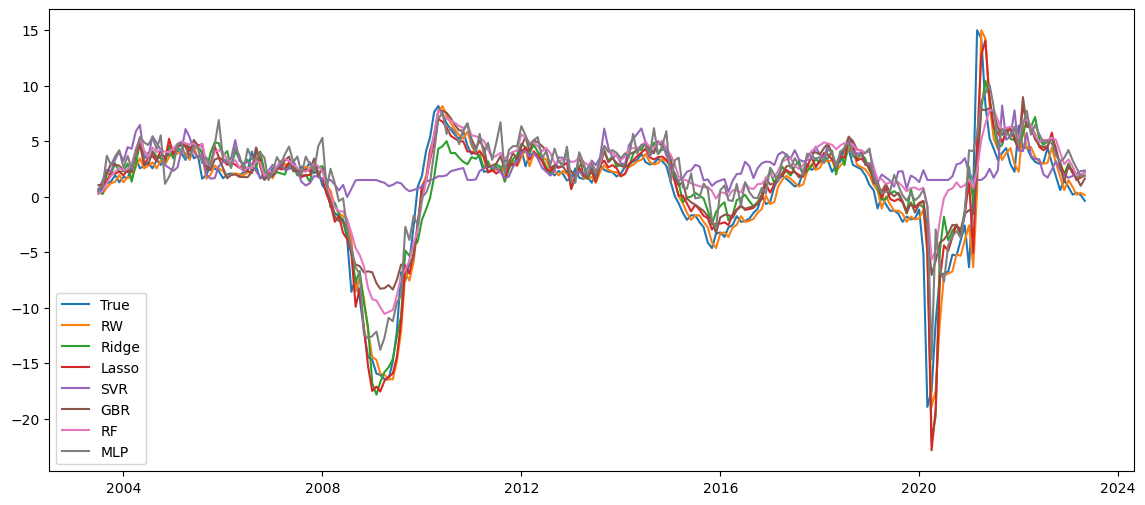

In [44]:
fix, ax = plt.subplots()

ax.plot(p_h0.test_sample[0], label="True")
ax.plot(p_h0.test_rw_prediction, label="RW")
ax.plot(r_h0[2], label="Ridge")
ax.plot(l_h0[2], label="Lasso")
ax.plot(svr_h0[2], label="SVR")
ax.plot(gbr_h0[2], label="GBR")
ax.plot(rf_h0[2], label="RF")
ax.plot(mlp_h0[2], label="MLP")

plt.legend(loc="best")
plt.show()

In [61]:
r_h3, l_h3, svr_h3, rf_h3, gbr_h3, mlp_h3, p_h3 = evaluate_models(df=data_with_indpro_yoy,
                       y_name=target_variable, 
                       autoregressive_lags=[0] + lags_s[0], 
                       lags=lags_s[0],
                       h_ahead=h_s[3],
                       standardize=True)

Ridge
--------------------------------------------------
Ridge: 3.27
Alpha: 5336.699231206302
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 3.2
Alpha: 4.328761281083062
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 3.37
C: 2.0, G: 0.0078125, eps: 0.0001
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 3.35
Max depth: 8, Max features: 3
--------------------------------------------------
GradientBoostingRegressor
--------------------------------------------------
GradientBoostingRegressor: 3.46
Subsample: 0.05, n estimators: 30, Max depth: 5
--------------------------------------------------
MLPRegressor
--------------------------------------------------
MLPRegressor: 3.25
Hidden layer sizes: (5, 5), alpha: 1000.0
--------------------------------------

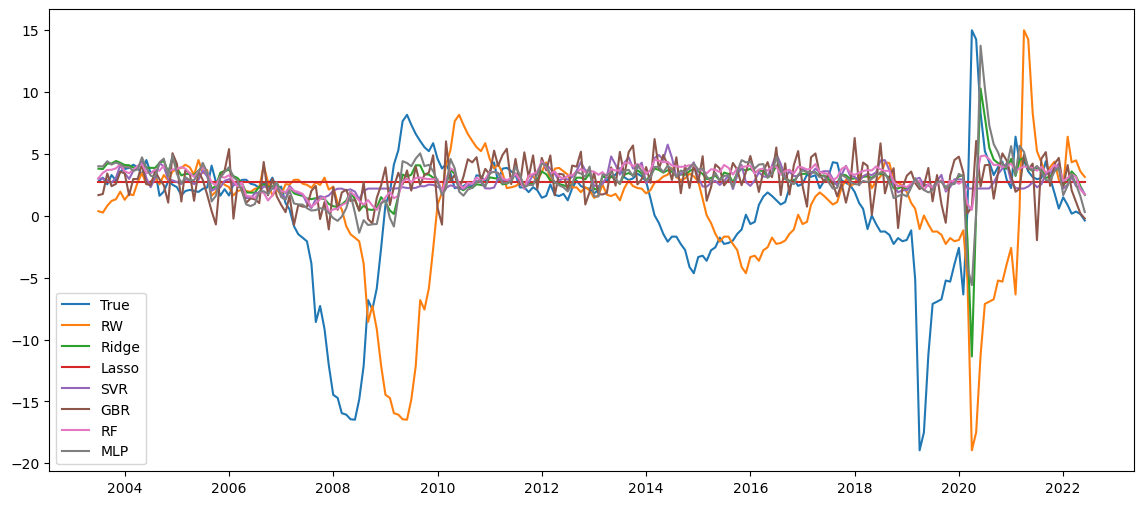

In [62]:
fix, ax = plt.subplots()

ax.plot(p_h3.test_sample[0], label="True")
ax.plot(p_h3.test_rw_prediction, label="RW")
ax.plot(r_h3[2], label="Ridge")
ax.plot(l_h3[2], label="Lasso")
ax.plot(svr_h3[2], label="SVR")
ax.plot(gbr_h3[2], label="GBR")
ax.plot(rf_h3[2], label="RF")
ax.plot(mlp_h3[2], label="MLP")

plt.legend(loc="best")
plt.show()

In [63]:
r_h3_l0, l_h3_l0, svr_h3_l0, rf_h3_l0, gbr_h3_l0, mlp_h3_l0, p_h3_l0 = evaluate_models(df=data_with_indpro_yoy,
                       y_name=target_variable, 
                       autoregressive_lags=[0], 
                       lags=[],
                       h_ahead=h_s[3],
                       standardize=True)

Ridge
--------------------------------------------------
Ridge: 3.3
Alpha: 3511.1917342151273
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 3.21
Alpha: 4.328761281083062
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 3.42
C: 2.0, G: 0.01968626640460739, eps: 0.0001
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 3.41
Max depth: 8, Max features: 3
--------------------------------------------------
GradientBoostingRegressor
--------------------------------------------------
GradientBoostingRegressor: 3.2
Subsample: 0.05, n estimators: 10, Max depth: 2
--------------------------------------------------
MLPRegressor
--------------------------------------------------
MLPRegressor: 3.31
Hidden layer sizes: (10, 10), alpha: 1000.0
--------------------------

In [64]:
baseline_with_changes_in_h = {}

for h in h_s:

    print("*"*100)
    print(h)
    r, l, svr, rf, gbr, mlp, p = evaluate_models(df=data_with_indpro_yoy,
                       y_name=target_variable, 
                       autoregressive_lags=[0], 
                       lags=[],
                       h_ahead=h,
                       standardize=True)
    baseline_with_changes_in_h[str(h)] = (r, l, svr, rf, gbr, mlp, p)
    print("*"*100)

****************************************************************************************************
1
Ridge
--------------------------------------------------
Ridge: 1.34
Alpha: 10.0
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 1.2
Alpha: 0.03511191734215131
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 2.89
C: 12.699208415745595, G: 0.0078125, eps: 0.5
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 2.05
Max depth: 5, Max features: 50
--------------------------------------------------
GradientBoostingRegressor
--------------------------------------------------
GradientBoostingRegressor: 1.71
Subsample: 0.9, n estimators: 150, Max depth: 5
--------------------------------------------------
MLPRegressor
---------------------------------------------

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPRegressor: 3.32
Hidden layer sizes: 5, alpha: 1000.0
--------------------------------------------------
RW: 2.96
--------------------------------------------------
****************************************************************************************************
****************************************************************************************************
12
Ridge
--------------------------------------------------
Ridge: 3.3
Alpha: 3511.1917342151273
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 3.21
Alpha: 4.328761281083062
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 3.42
C: 2.0, G: 0.01968626640460739, eps: 0.0001
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 3.41
Max depth: 8, Max features: 3
---------------------------------------

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPRegressor: 3.73
Hidden layer sizes: (10, 10), alpha: 1000.0
--------------------------------------------------
RW: 5.9
--------------------------------------------------
****************************************************************************************************


In [87]:
np.mean(baseline_with_changes_in_h["12"][0][0][3511.1917342151273])

2.612369137240492

In [89]:
np.mean(baseline_with_changes_in_h["12"][1][0][4.328761281083062])

2.7924635783605893

In [92]:
np.mean(baseline_with_changes_in_h["12"][2][0]["2.0, 0.01968626640460739, 0.0001"])

2.3958635149380356

In [95]:
np.mean(baseline_with_changes_in_h["12"][3][0]["8, 3"])

2.508077024711404

In [99]:
np.mean(baseline_with_changes_in_h["12"][4][0]['0.05, 10, 2'])

2.488636769748821

In [106]:
np.mean(baseline_with_changes_in_h["12"][5][0]['(10, 10); 1000'])

2.6328687422680397

In [109]:
np.mean(baseline_with_changes_in_h["12"][-1].rw_errors)

2.9272695706069736

In [141]:
mean_absolute_error(y_pred=baseline_with_changes_in_h["12"][5][2].iloc[144:], y_true=baseline_with_changes_in_h["12"][-1].test_sample[0].iloc[144:])

3.8078891329225812

In [142]:
mean_absolute_error(y_pred=baseline_with_changes_in_h["12"][-1].test_rw_prediction.iloc[144:], y_true=baseline_with_changes_in_h["12"][-1].test_sample[0].iloc[144:])

5.22302369650502

In [79]:
baseline_with_changes_in_h["12"][-1].train_val[-1][2]

sasdate
1998-01-01    3.573565
1998-02-01    3.978636
1998-03-01    4.155550
1998-04-01    4.040109
1998-05-01    3.994450
1998-06-01    4.519438
1998-07-01    5.510989
1998-08-01    3.903769
1998-09-01    3.588107
1998-10-01    4.170076
1998-11-01    4.797662
1998-12-01    5.195126
1999-01-01    4.699812
1999-02-01    4.468646
1999-03-01    4.637147
1999-04-01    5.054752
1999-05-01    4.717136
1999-06-01    4.859676
1999-07-01    4.091700
1999-08-01    3.389068
1999-09-01    4.206189
1999-10-01    2.577797
1999-11-01    2.070349
1999-12-01    0.928321
2000-01-01    0.507542
2000-02-01   -0.485393
2000-03-01   -1.136483
2000-04-01   -2.131335
2000-05-01   -2.925939
2000-06-01   -3.545599
2000-07-01   -3.976758
2000-08-01   -3.813376
2000-09-01   -4.732838
2000-10-01   -4.695219
2000-11-01   -5.301364
2000-12-01   -5.008809
2001-01-01   -3.797153
2001-02-01   -3.143826
2001-03-01   -2.142217
2001-04-01   -1.304749
2001-05-01   -0.359284
2001-06-01    1.007742
2001-07-01    1.578382
200

<Axes: xlabel='sasdate'>

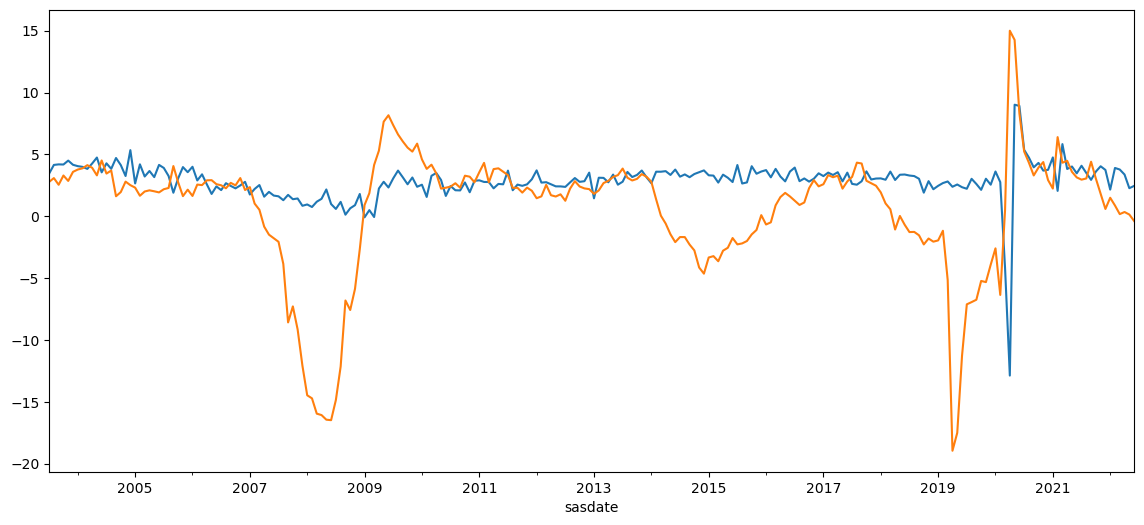

In [72]:
baseline_with_changes_in_h["12"][0][2].plot()
baseline_with_changes_in_h["12"][-1].test_sample[0].plot()

### Richer lag structure

In [469]:
baseline_with_changes_in_h["12"][-1].train_val[0][0]

sasdate
1965-01-01    9.159056
1965-02-01    9.185230
1965-03-01    9.229556
1965-04-01    8.953879
1965-05-01    9.123282
                ...   
1994-08-01    4.499563
1994-09-01    4.588104
1994-10-01    3.612445
1994-11-01    3.187176
1994-12-01    2.534198
Name: INDPRO, Length: 360, dtype: float64

In [148]:
baseline_with_changes_in_l = {}

for lags in lags_s:

    print("*"*100)
    print(lags)
    r, l, svr, rf, gbr, mlp, p = evaluate_models(df=data_with_indpro_yoy,
                       y_name=target_variable, 
                       autoregressive_lags=[0] + lags, 
                       lags=lags,
                       h_ahead=12,
                       standardize=True)
    baseline_with_changes_in_l[str(lags)] = (r, l, svr, rf, gbr, mlp, p)
    print("*"*100)

****************************************************************************************************
[12]
Ridge
--------------------------------------------------
Ridge: 3.17
Alpha: 10000.0
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 3.16
Alpha: 4.328761281083062
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 3.38
C: 23.515751876409578, G: 0.0078125, eps: 0.5
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 3.32
Max depth: 8, Max features: 3
--------------------------------------------------
GradientBoostingRegressor
--------------------------------------------------
GradientBoostingRegressor: 3.41
Subsample: 0.1, n estimators: 10, Max depth: 2
--------------------------------------------------
MLPRegressor
------------------------------------------

### Application of PCA

In [156]:
baseline_with_pca = {}

for n_pc in [3, 5, 8, 13, 21]:

    print("*"*100)
    print(n_pc)
    r, l, svr, rf, gbr, mlp, p = evaluate_models(df=data_with_indpro_yoy,
                       y_name=target_variable, 
                       autoregressive_lags=[0], 
                       lags=[],
                       start_rolling_std="1970-01-01",
                       size_train=300,
                       h_ahead=12,
                       standardize=True,
                       use_pca=True, 
                       num_components=n_pc)
    baseline_with_pca[n_pc] = (r, l, svr, rf, gbr, mlp, p)
    print("*"*100)

****************************************************************************************************
3
Ridge
--------------------------------------------------
Ridge: 3.16
Alpha: 8111.308307896856
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 3.16
Alpha: 8.111308307896872
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 3.75
C: 23.515751876409578, G: 0.0078125, eps: 0.0001
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 3.48
Max depth: 2, Max features: 3
--------------------------------------------------
GradientBoostingRegressor
--------------------------------------------------
GradientBoostingRegressor: 3.41
Subsample: 0.1, n estimators: 10, Max depth: 2
--------------------------------------------------
MLPRegressor
--------------------------------

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPRegressor: 3.24
Hidden layer sizes: (5, 5), alpha: 1000.0
--------------------------------------------------
RW: 4.62
--------------------------------------------------
****************************************************************************************************


In [174]:
X_normalized_copy = baseline_with_changes_in_h["12"][-1].X.copy()
del X_normalized_copy["INDPRO, 0-month lag"]

pcs_copy = baseline_with_pca[8][-1].X.copy()
del pcs_copy["INDPRO, 0-month lag"]

In [175]:
explanatory_power = {}

for i in X_normalized_copy.columns:
    explanatory_power_for_each_input = {}
    for ii in range(pcs_copy.shape[1]):
        X = pcs_copy.iloc[:, :(ii + 1)].to_numpy()
        y = X_normalized_copy[i].to_numpy()
        reg = LinearRegression().fit(X, y)
        explanatory_power_for_each_input[ii] = reg.score(X, y)
    
    explanatory_power[i] = explanatory_power_for_each_input 

In [176]:
explanatory_power_df = pd.DataFrame(explanatory_power)
incremental_explanatory_power = explanatory_power_df.copy()

for i in range(explanatory_power_df.shape[0] - 1, 0, -1):
    incremental_explanatory_power.iloc[i, :] = explanatory_power_df.iloc[i, :] - explanatory_power_df.iloc[i-1, :]
explanatory_power_df

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,...,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST
0,0.000279,0.271990,0.293009,0.393591,0.269779,0.655167,0.585781,0.425281,0.458132,0.132816,...,0.003647,0.002636,0.000968,0.001602,0.002134,0.000118,0.000448,0.000429,0.002517,0.000536
1,0.008961,0.308456,0.351599,0.463794,0.290226,0.772711,0.705262,0.578157,0.592992,0.185698,...,0.004261,0.003095,0.002615,0.001617,0.006569,0.000211,0.007052,0.001233,0.004052,0.000572
2,0.020849,0.314136,0.403127,0.489720,0.336153,0.811222,0.752029,0.620843,0.630393,0.217977,...,0.084561,0.007792,0.099017,0.002162,0.006846,0.000400,0.013942,0.002643,0.004291,0.000619
3,0.032220,0.316059,0.431708,0.507975,0.357926,0.838695,0.792287,0.664221,0.652734,0.247865,...,0.101233,0.010888,0.111726,0.005389,0.044415,0.010033,0.053822,0.020750,0.043280,0.000799
4,0.097638,0.333044,0.432380,0.513368,0.371531,0.840973,0.795770,0.665459,0.652736,0.250182,...,0.126049,0.013336,0.158354,0.005395,0.105799,0.037363,0.087475,0.103652,0.209780,0.017384
5,0.102971,0.375988,0.432518,0.516447,0.383899,0.844368,0.800798,0.666332,0.658527,0.250811,...,0.637702,0.040443,0.731402,0.029371,0.110543,0.041272,0.088513,0.103942,0.210626,0.017458
6,0.120381,0.379772,0.454559,0.540755,0.419469,0.856031,0.811791,0.694776,0.684129,0.261860,...,0.641786,0.041827,0.731473,0.040828,0.110998,0.041881,0.096731,0.107549,0.249604,0.026887
7,0.125135,0.380985,0.457153,0.542635,0.419609,0.900746,0.871555,0.780129,0.699561,0.361380,...,0.703092,0.058330,0.765934,0.058617,0.111062,0.042209,0.096884,0.150723,0.311866,0.035202


In [185]:
incremental_explanatory_power.index = [f"PC {i+1}" for i in range(8)]
incremental_explanatory_power.T.sort_values("PC 1", ascending=False)["PC 1"][:10]

PAYEMS       0.769088
USGOOD       0.768886
IPMANSICS    0.719349
MANEMP       0.715936
DMANEMP      0.693230
CUMFNS       0.661065
IPFPNSS      0.655167
IPDMAT       0.628350
USTPU        0.621049
SRVPRD       0.609567
Name: PC 1, dtype: float64

In [186]:
incremental_explanatory_power.T.sort_values("PC 2", ascending=False)["PC 2"][:10]

T10YFFM      0.662538
T5YFFM       0.657904
AAAFFM       0.648383
BAAFFM       0.625992
TB6SMFFM     0.546600
T1YFFM       0.536771
TB3SMFFM     0.517326
COMPAPFFx    0.367086
BUSINVx      0.219309
CUMFNS       0.154965
Name: PC 2, dtype: float64

In [179]:
incremental_explanatory_power.T.sort_values("PC 3", ascending=False)["PC 3"][:10]

GS1        0.314789
TB6MS      0.286083
GS5        0.251982
TB3MS      0.249497
PERMIT     0.230990
HOUST      0.222034
GS10       0.216854
PERMITW    0.209494
HOUSTS     0.199257
CP3Mx      0.193342
Name: PC 3, dtype: float64

In [180]:
incremental_explanatory_power.T.sort_values("PC 4", ascending=False)["PC 4"][:10]

BAA              0.210761
AAA              0.205463
S&P div yield    0.184494
HOUST            0.182379
GS1              0.178130
GS5              0.172138
PERMIT           0.170767
GS10             0.169333
TB6MS            0.166492
PERMITW          0.163360
Name: PC 4, dtype: float64

In [181]:
incremental_explanatory_power.T.sort_values("PC 5", ascending=False)["PC 5"][:10]

DTCTHFNM         0.166500
S&P 500          0.154286
S&P: indust      0.145323
NONREVSL         0.139551
S&P div yield    0.125001
AAA              0.124053
BAA              0.118099
S&P PE ratio     0.107666
CONSPI           0.105208
DTCOLNVHFNM      0.082902
Name: PC 5, dtype: float64

In [182]:
incremental_explanatory_power.T.sort_values("PC 6", ascending=False)["PC 6"][:10]

CUSR0000SAC        0.581002
DNDGRG3M086SBEA    0.573048
CUSR0000SA0L2      0.560644
CPIAUCSL           0.536196
CUSR0000SA0L5      0.516118
PCEPI              0.511654
CPITRNSL           0.434960
WPSFD49502         0.409964
WPSFD49207         0.398410
CPIULFSL           0.392779
Name: PC 6, dtype: float64

In [187]:
incremental_explanatory_power.T.sort_values("PC 7", ascending=False)["PC 7"][:10]

S&P PE ratio     0.293082
S&P: indust      0.286690
S&P 500          0.281382
S&P div yield    0.267093
TOTRESNS         0.123676
NONBORRES        0.093633
ISRATIOx         0.071089
BOGMBASE         0.068160
HOUSTNE          0.058415
PERMITNE         0.058037
Name: PC 7, dtype: float64

In [238]:
incremental_explanatory_power.T.sort_values("PC 8", ascending=False)["PC 8"][:10]

UEMPLT5          0.144852
HWIURATIO        0.124023
IPNCONGD         0.099520
UNRATE           0.094895
S&P: indust      0.092008
S&P 500          0.091315
IPCONGD          0.085352
S&P div yield    0.065531
TB3MS            0.062465
DTCTHFNM         0.062263
Name: PC 8, dtype: float64

In [192]:
#baseline_with_pca[8][-1].test_sample[0].plot()

In [202]:
true_index = pd.date_range("2004-07-01", "2023-07-01", freq="M")
true_index

DatetimeIndex(['2004-07-31', '2004-08-31', '2004-09-30', '2004-10-31',
               '2004-11-30', '2004-12-31', '2005-01-31', '2005-02-28',
               '2005-03-31', '2005-04-30',
               ...
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30'],
              dtype='datetime64[ns]', length=228, freq='M')

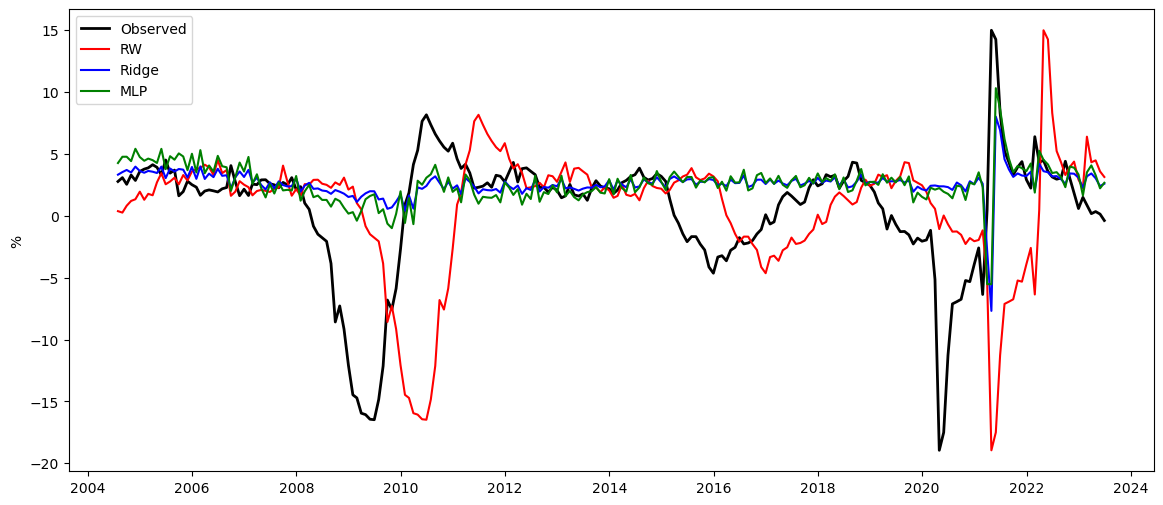

In [217]:
fix, ax = plt.subplots()

ax.plot(true_index, baseline_with_pca[8][-1].test_sample[0], label="Observed", color="black", linewidth=2)
ax.plot(true_index, baseline_with_pca[8][-1].test_rw_prediction, label="RW", color="red")
ax.plot(true_index, baseline_with_pca[8][0][2], label="Ridge", color="blue")
#ax.plot(gbr[2], label="GBR")
#ax.plot(rf[2], label="RF")
ax.plot(true_index, baseline_with_pca[8][-2][2], label="MLP", color="green")
ax.set_ylabel("%")

plt.legend(loc="best")
#plt.show()

plt.savefig("Forecast_comparison.png")

### Feature Importance

In [239]:
model_gbr = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0], 
                 model=GradientBoostingRegressor(subsample=0.1, 
                                     n_estimators=10,
                                     loss='absolute_error', 
                                     max_depth=8,
                                     random_state=92834),
                start_rolling_std="1970-01-01",
                size_train=300,       
                lags=[], 
                h_ahead=12,
                standardize=True,
                use_pca=True, 
                num_components=8)     

model_gbr.prepare_data()
model_gbr.generate_train_val_samples()
model_gbr.train_validate_model()

In [240]:
import shap

model_gbr.X.columns = ["Manufacturing and employment", "Interest rate spreads",
                       "ST interest rate and housing",
                        "Corporate bond yields",
                        "Credit", "Inflation", "Stock market",
                          "Labor market", 
                          "Lagged Industrial production YoY"]
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model_gbr.model)
shap_values = explainer(model_gbr.X)

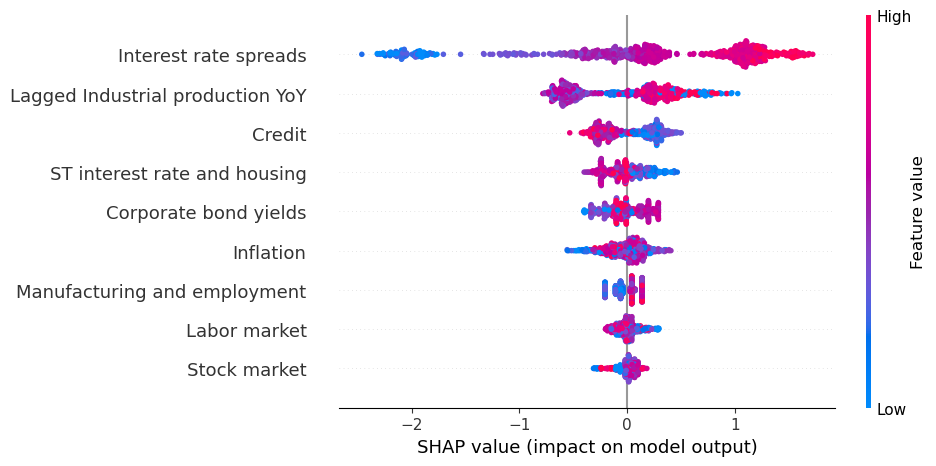

In [241]:
shap.plots.beeswarm(shap_values)

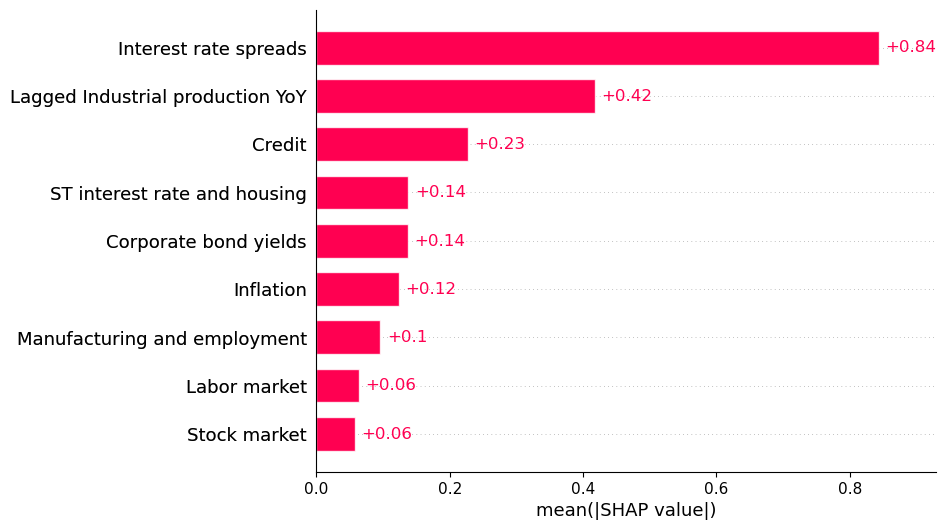

In [243]:
shap.plots.bar(shap_values)

## Alternative datasets

### Canada

In [280]:
df_canada = pd.read_csv("LCDMA_January_2024/TR_CAN_MD.csv")
#df_canada.drop(columns = ['Unnamed: 0'], inplace=True)
df_canada.index = df_canada["Date"]
del df_canada["Date"]

df_canada["IP_new"] = np.log((df_canada["IP_new"] + 1).cumprod()).diff(12) * 100

df_canada.head()

,GDP_new,BSI_new,GPI_new,SPI_new,IP_new,NDM_new,DM_new,OILP_new,CON_new,RT_new,...,CPI_MINUS_FOO_BC,CPI_MINUS_FEN_BC,CPI_GOO_BC,CPI_DUR_BC,CPI_SERV_BC,CRED_T_discontinued,CRED_HOUS_discontinued,CRED_MORT_discontinued,CRED_CONS_discontinued,CRE_BUS_discontinued
Date,,,,,,,,,,,,,,,,,,,,,
1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [307]:
df_canada_short = df_canada.iloc[df_canada.index.get_loc("1982-02-01"):-6]
df_canada_indprod_yoy = df_canada_short.dropna(axis=1)
df_canada_indprod_yoy.index = pd.to_datetime(df_canada_indprod_yoy.index) 
df_canada_indprod_yoy

,GDP_new,BSI_new,GPI_new,SPI_new,IP_new,NDM_new,DM_new,OILP_new,CON_new,RT_new,...,CPI_SERV_ALB,CPI_ALL_BC,CPI_SHEL_BC,CPI_CLOT_BC,CPI_HEA_BC,CPI_MINUS_FOO_BC,CPI_MINUS_FEN_BC,CPI_GOO_BC,CPI_DUR_BC,CPI_SERV_BC
Date,,,,,,,,,,,,,,,,,,,,,
1982-02-01,0.005641,0.007771,0.005921,0.005512,-4.567453,-0.004178,0.011363,0.009578,0.009718,0.016495,...,0.013766,0.007233,0.009908,0.028848,0.011132,0.007207,0.008937,0.005352,-0.002981,0.007299
1982-03-01,-0.006450,-0.008571,-0.007950,-0.005512,-5.932819,-0.015296,-0.018196,-0.002823,0.001141,-0.016495,...,0.017425,0.007181,0.008415,0.015674,0.012832,0.010714,0.005324,0.008857,-0.001494,0.003630
1982-04-01,-0.009200,-0.011712,-0.018278,-0.003521,-10.675490,-0.016044,-0.023281,-0.058293,-0.001432,-0.022006,...,0.011451,0.007130,0.005571,-0.020425,0.001820,0.001775,0.001768,0.005277,-0.005997,0.007220
1982-05-01,0.002798,0.003345,0.004248,0.001880,-7.866761,0.005116,-0.023252,0.070007,-0.010558,0.004611,...,0.011321,0.012357,0.008299,0.014185,0.032203,0.012335,0.012292,0.017392,0.017884,0.010734
1982-06-01,-0.010060,-0.012796,-0.015532,-0.006631,-10.363775,-0.020903,-0.029107,-0.008891,-0.008089,-0.032436,...,0.005613,0.006993,0.004124,0.003125,0.003515,0.005240,0.003484,0.006873,-0.008902,0.003552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,0.001913,0.001551,0.002136,0.001833,1.266282,-0.011481,0.015417,0.015060,-0.004209,0.003324,...,0.001099,0.006730,0.006112,0.026668,-0.003659,0.006261,0.005772,0.007067,0.008742,0.005823
2023-03-01,0.002076,0.002034,0.004339,0.001266,1.070895,0.013855,-0.001405,0.013245,0.001557,-0.005929,...,0.003837,0.004016,0.002029,0.031455,0.010937,0.006222,0.005739,0.004917,0.003861,0.003221
2023-04-01,-0.000092,0.001077,-0.000918,0.000203,0.120992,-0.005578,-0.005775,0.006475,0.001789,0.008130,...,0.005999,0.004665,0.006063,0.000910,0.012252,0.004813,0.004995,0.005591,0.004805,0.004492


In [308]:
baseline_with_pca_canada = {}

for n_pc in [3, 5, 8, 13, 21]:

    print("*"*100)
    print(n_pc)
    r, l, svr, rf, gbr, mlp, p = evaluate_models(df=df_canada_indprod_yoy,
                       y_name="IP_new", 
                       autoregressive_lags=[0], 
                       lags=[],
                       start_rolling_std="1992-01-01",
                       size_train=180,
                       size_val=60,
                       latest_start_test="2017-01-01",
                       h_ahead=12,
                       standardize=True,
                       use_pca=True, 
                       num_components=n_pc)
    baseline_with_pca_canada[n_pc] = (r, l, svr, rf, gbr, mlp, p)
    print("*"*100)

****************************************************************************************************
3
Ridge
--------------------------------------------------
Ridge: 4.18
Alpha: 10000.0
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 4.19
Alpha: 5.336699231206313
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 4.25
C: 2.0, G: 0.0078125, eps: 0.5
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 4.23
Max depth: 2, Max features: 5
--------------------------------------------------
GradientBoostingRegressor
--------------------------------------------------
GradientBoostingRegressor: 4.21
Subsample: 0.1, n estimators: 5, Max depth: 2
--------------------------------------------------
MLPRegressor
--------------------------------------------------
MLPRegress

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPRegressor: 4.19
Hidden layer sizes: (10, 10), alpha: 1000.0
--------------------------------------------------
RW: 6.87
--------------------------------------------------
****************************************************************************************************
****************************************************************************************************
8
Ridge
--------------------------------------------------
Ridge: 4.31
Alpha: 1519.9110829529332
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 4.19
Alpha: 5.336699231206313
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 4.24
C: 2.0, G: 0.0078125, eps: 0.5
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 4.29
Max depth: 2, Max features: 3
---------------------------------------------

In [329]:
baseline_with_pca_canada[21][-1].test_sample[0]

Date
2017-01-01    1.669342
2017-02-01    2.817228
2017-03-01    3.615364
2017-04-01    3.193932
2017-05-01    1.862730
                ...   
2022-02-01    1.266282
2022-03-01    1.070895
2022-04-01    0.120992
2022-05-01    0.343554
2022-06-01   -0.210821
Name: IP_new, Length: 66, dtype: float64

In [312]:
canadian_PCs = baseline_with_pca_canada[21][-1].X.copy()
canadian_PCs.columns = [f"Canada f{i}" for i in range(22)]
canadian_PCs

,Canada f0,Canada f1,Canada f2,Canada f3,Canada f4,Canada f5,Canada f6,Canada f7,Canada f8,Canada f9,...,Canada f12,Canada f13,Canada f14,Canada f15,Canada f16,Canada f17,Canada f18,Canada f19,Canada f20,Canada f21
1982-02-01,15.163178,-2.938886,-1.368948,-2.793384,9.911258,1.532563,-0.443194,-0.242072,2.702653,-1.634090,...,-1.679518,-0.377025,-4.769516,2.908951,0.574940,1.484159,-3.688326,3.323676,-1.695718,-0.982140
1982-03-01,18.553188,-1.293208,-3.708678,3.156192,-0.435794,3.531824,-5.359493,-0.301845,-0.675546,1.639347,...,0.521233,-3.324850,3.509888,-3.397326,1.359883,-0.113322,2.138629,0.745041,1.977957,-1.197101
1982-04-01,6.233159,11.301863,-1.717944,0.107344,2.699182,6.474523,8.413218,-1.142994,2.711988,-2.281858,...,-1.491963,-1.372987,-5.952641,1.706537,1.497044,-1.107996,-1.518608,-0.822074,-1.569366,-1.943780
1982-05-01,15.565239,1.268936,6.349393,5.283089,3.390492,0.501850,-9.529494,-7.227466,-7.410640,-3.885541,...,-1.634094,0.557348,-2.255512,0.433878,-1.255085,-3.702606,0.027318,1.544423,0.473016,-1.501578
1982-06-01,8.276424,6.266631,-3.348242,5.167924,9.328766,5.986223,9.646217,0.572247,0.624998,-2.540240,...,-0.354201,-0.111865,1.927841,-4.150586,2.796945,0.841790,-1.465491,-4.036798,-0.441485,-1.894704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,4.844132,-13.740685,2.163171,0.935487,-0.071380,2.293606,0.974393,3.027397,2.465914,-1.469547,...,-0.326168,1.113458,2.751743,-0.667829,-4.843306,-1.873913,1.799471,-1.406677,2.516652,0.331994
2022-03-01,15.871744,-11.655960,5.758579,6.904479,0.943880,1.431852,-2.069556,2.217756,1.700394,2.072188,...,-0.659340,-0.772368,-0.063766,-0.681402,-1.239233,-0.359189,-1.737711,-2.992434,2.102280,0.411026
2022-04-01,8.964613,-4.898834,-2.913195,-1.659456,-0.959436,3.342878,2.105807,-1.870302,0.521198,1.400093,...,0.048661,-0.367041,-0.468407,-3.398466,1.309911,1.397656,1.391785,1.317510,0.269301,0.949434
2022-05-01,17.066222,-8.122954,-0.770568,5.259069,0.766752,0.680773,-0.529088,3.738713,2.062755,0.113552,...,0.547730,-1.449913,-0.210747,1.317120,-1.071423,-0.020171,-0.438934,-0.144435,2.303994,0.872762


In [415]:
us_PCs = baseline_with_pca[8][-1].X.copy()#.loc[df_canada_indprod_yoy.index]
us_PCs.columns = [f"US f{i}" for i in range(9)]
us_PCs

,US f0,US f1,US f2,US f3,US f4,US f5,US f6,US f7,US f8
1960-01-01,-4.763222,6.491765,1.654933,-4.578943,-3.655919,2.290570,3.256028,2.111533,1.083472
1960-02-01,1.797081,-1.262788,2.479989,3.018402,1.482714,1.228514,6.446423,-1.657056,0.356393
1960-03-01,11.054052,-2.026512,7.130488,-1.685552,0.476172,-1.619144,-0.485540,5.935901,-0.242248
1960-04-01,0.722976,-3.469026,1.901750,7.244510,6.755155,1.087737,0.018068,-4.320699,-0.987414
1960-05-01,5.947212,0.815018,-5.944824,-5.936804,-3.237312,2.951090,0.095164,2.955039,-1.400552
...,...,...,...,...,...,...,...,...,...
2022-02-01,-4.822099,0.533558,-0.527332,-0.996183,1.907197,-0.911284,1.786944,-1.125573,0.827193
2022-03-01,-4.398073,0.990650,-1.878373,-0.112671,1.543402,-0.101052,1.663500,-1.176429,0.400765
2022-04-01,-2.095319,1.251737,-3.876736,-0.541651,0.125630,3.568591,1.361019,1.601197,0.431929
2022-05-01,-0.860351,-0.747104,-1.241870,-3.179700,4.282011,-3.466505,3.069040,-1.600363,0.247933


In [414]:
merged_df_canada_us = pd.concat([us_PCs.iloc[us_PCs.index.get_loc("1982-02-01"):], canadian_PCs, baseline_with_pca_canada[21][-1].y],axis=1)
#merged_df_canada_us = merged_df_canada_us.iloc[merged_df_canada_us.index.get_loc("1991-11-01"):]
#merged_df_canada_us

In [364]:
r, l, svr, rf, gbr, mlp, p = evaluate_models(df=merged_df_canada_us,
                       y_name="IP_new", 
                       autoregressive_lags=[], 
                       lags=[],
                       start_rolling_std="1991-12-01",
                       size_train=180,
                       size_val=60,
                       latest_start_test="2017-01-01",
                       h_ahead=0)

Ridge
--------------------------------------------------
Ridge: 4.18
Alpha: 10000.0
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 4.19
Alpha: 3.5111917342151346
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 4.25
C: 2.0, G: 0.31498026247371824, eps: 0.0001
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 4.36
Max depth: 2, Max features: 3
--------------------------------------------------
GradientBoostingRegressor
--------------------------------------------------
GradientBoostingRegressor: 4.16
Subsample: 0.05, n estimators: 5, Max depth: 2
--------------------------------------------------
MLPRegressor
--------------------------------------------------


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPRegressor: 4.19
Hidden layer sizes: (10, 10), alpha: 1000.0
--------------------------------------------------
RW: 0.0
--------------------------------------------------


### The UK

In [416]:
df_uk = pd.read_csv("UKMD_January_2024/tr_uk_md.csv")
#df_canada.drop(columns = ['Unnamed: 0'], inplace=True)
df_uk.index = df_uk["Date"]
del df_uk["Date"]
df_uk["IOP_PROD"] = np.log((df_uk["IOP_PROD"] + 1).cumprod()).diff(12) * 100
del df_uk["Unnamed: 0"]
df_uk.head()

,EMP,EMP_PART,EMP_TEMP,UNEMP_RATE,UNEMP_DURA_6mth,UNEMP_DURA_6.12mth,UNEMP_DURA_12mth.,UNEMP_DURA_24mth.,EMP_RATE,EMP_ACT,...,UK_focused_equity,EUR_UNC_INDEX,BCI,CCI,CLI,PPI_MANU,PPI_MACH,PPI_OIL,PPI_METAL,PPI_MOTOR
Date,,,,,,,,,,,,,,,,,,,,,
1948-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [417]:
df_uk.isna().iloc[400:].sum(axis=1)

Date
1981-05-01    84
1981-06-01    84
1981-07-01    84
1981-08-01    84
1981-09-01    84
              ..
2023-08-01    11
2023-09-01    11
2023-10-01    11
2023-11-01    14
2023-12-01    60
Length: 512, dtype: int64

In [418]:
df_uk_short = df_uk.iloc[df_uk.index.get_loc("1982-02-01"):-6]
df_uk_indprod_yoy = df_uk_short.dropna(axis=1)
df_uk_indprod_yoy.index = pd.to_datetime(df_uk_indprod_yoy.index) 
df_uk_indprod_yoy

,EMP,UNEMP_RATE,EMP_RATE,EMP_ACT,EMP_ACT_RATE,CLAIMS,CLAIMS_RATE,TOT_WEEK_HRS,IOP_PROD,IOP_MACH,...,GBP_CAN,GBP_JAP,GBP_US,BANK_RATE,FTSE_ALL,SP500,BCI,CCI,CLI,PPI_MANU
Date,,,,,,,,,,,,,,,,,,,,,
1982-02-01,-0.000787,0.0,-0.1,-0.000303,0.0,0.005272,0.0,-0.000494,1.949365,0.006636,...,-0.003963,0.026263,-0.021799,-0.3438,-0.043352,-0.062459,-0.01137,0.28116,0.08093,0.006048
1982-03-01,-0.001162,0.1,-0.1,-0.000530,-0.1,0.004131,0.0,-0.000988,2.116589,0.013141,...,-0.016238,0.001245,-0.021676,-0.4765,0.030151,-0.010219,0.08599,0.59015,0.11670,0.005471
1982-04-01,-0.001038,0.0,-0.1,-0.000303,-0.1,0.011682,0.1,-0.001113,3.096044,-0.027798,...,-0.016229,-0.008723,-0.019613,-0.1891,0.004582,0.039234,-0.07408,0.70573,0.09024,0.002304
1982-05-01,-0.001663,0.1,-0.1,-0.000682,-0.1,0.005851,0.1,-0.001857,5.296120,0.040768,...,0.029294,-0.007018,0.021990,-0.0500,0.028159,-0.039949,-0.13669,0.79390,0.08301,0.004226
1982-06-01,-0.001458,0.0,-0.2,-0.000721,-0.1,0.012280,0.1,-0.001612,1.938784,-0.044803,...,0.001565,0.028615,-0.030092,-0.3864,-0.044445,-0.020498,-0.13212,0.56668,0.12821,0.002213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,0.001365,0.1,0.1,0.002316,0.1,-0.012462,-0.1,0.001427,-2.325464,0.013882,...,-0.009977,0.008663,-0.012089,0.4750,0.011392,-0.026459,-0.25260,0.81504,0.55853,-0.003351
2023-03-01,0.002845,-0.1,0.1,0.000943,0.0,0.017522,0.1,0.006160,-1.272346,-0.004251,...,0.021302,0.008115,0.004046,0.1011,-0.034651,0.034451,-0.25312,0.91417,0.52006,-0.000416
2023-04-01,-0.001089,0.2,0.0,0.002308,0.2,0.015221,0.0,-0.003407,-1.062257,0.011647,...,0.010841,0.024836,0.025787,0.1739,0.029842,0.014536,-0.29778,1.04318,0.47497,-0.002004


<Axes: xlabel='Date'>

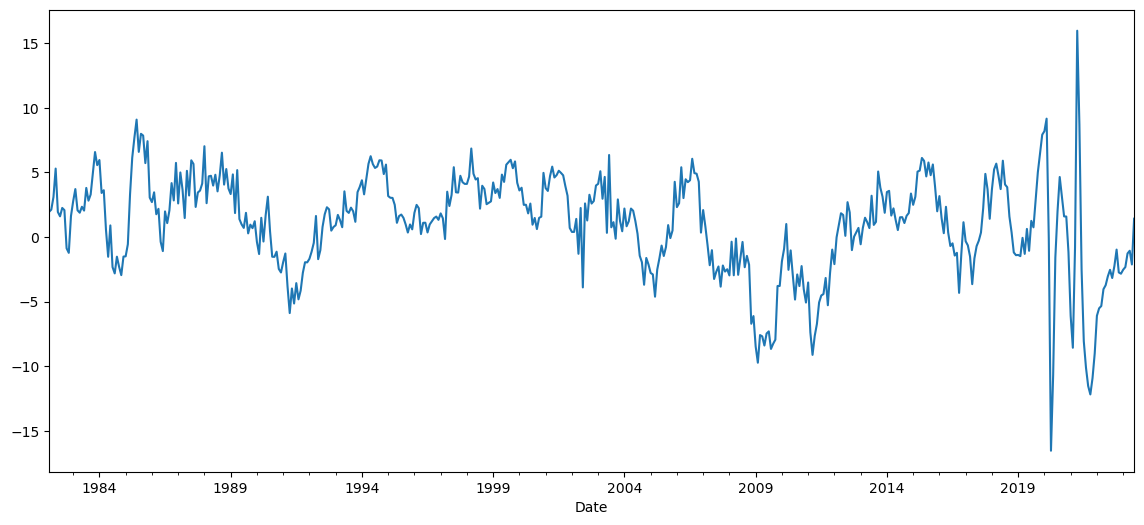

In [419]:
df_uk_indprod_yoy["IOP_PROD"].plot()

In [420]:
df_uk_indprod_yoy

,EMP,UNEMP_RATE,EMP_RATE,EMP_ACT,EMP_ACT_RATE,CLAIMS,CLAIMS_RATE,TOT_WEEK_HRS,IOP_PROD,IOP_MACH,...,GBP_CAN,GBP_JAP,GBP_US,BANK_RATE,FTSE_ALL,SP500,BCI,CCI,CLI,PPI_MANU
Date,,,,,,,,,,,,,,,,,,,,,
1982-02-01,-0.000787,0.0,-0.1,-0.000303,0.0,0.005272,0.0,-0.000494,1.949365,0.006636,...,-0.003963,0.026263,-0.021799,-0.3438,-0.043352,-0.062459,-0.01137,0.28116,0.08093,0.006048
1982-03-01,-0.001162,0.1,-0.1,-0.000530,-0.1,0.004131,0.0,-0.000988,2.116589,0.013141,...,-0.016238,0.001245,-0.021676,-0.4765,0.030151,-0.010219,0.08599,0.59015,0.11670,0.005471
1982-04-01,-0.001038,0.0,-0.1,-0.000303,-0.1,0.011682,0.1,-0.001113,3.096044,-0.027798,...,-0.016229,-0.008723,-0.019613,-0.1891,0.004582,0.039234,-0.07408,0.70573,0.09024,0.002304
1982-05-01,-0.001663,0.1,-0.1,-0.000682,-0.1,0.005851,0.1,-0.001857,5.296120,0.040768,...,0.029294,-0.007018,0.021990,-0.0500,0.028159,-0.039949,-0.13669,0.79390,0.08301,0.004226
1982-06-01,-0.001458,0.0,-0.2,-0.000721,-0.1,0.012280,0.1,-0.001612,1.938784,-0.044803,...,0.001565,0.028615,-0.030092,-0.3864,-0.044445,-0.020498,-0.13212,0.56668,0.12821,0.002213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,0.001365,0.1,0.1,0.002316,0.1,-0.012462,-0.1,0.001427,-2.325464,0.013882,...,-0.009977,0.008663,-0.012089,0.4750,0.011392,-0.026459,-0.25260,0.81504,0.55853,-0.003351
2023-03-01,0.002845,-0.1,0.1,0.000943,0.0,0.017522,0.1,0.006160,-1.272346,-0.004251,...,0.021302,0.008115,0.004046,0.1011,-0.034651,0.034451,-0.25312,0.91417,0.52006,-0.000416
2023-04-01,-0.001089,0.2,0.0,0.002308,0.2,0.015221,0.0,-0.003407,-1.062257,0.011647,...,0.010841,0.024836,0.025787,0.1739,0.029842,0.014536,-0.29778,1.04318,0.47497,-0.002004


In [421]:
baseline_with_pca_uk = {}

for n_pc in [3, 5, 8, 13, 21]:

    print("*"*100)
    print(n_pc)
    r, l, svr, rf, gbr, mlp, p = evaluate_models(df=df_uk_indprod_yoy,
                       y_name="IOP_PROD", 
                       autoregressive_lags=[0], 
                       lags=[],
                       start_rolling_std="1992-01-01",
                       size_train=180,
                       size_val=60,
                       latest_start_test="2017-01-01",
                       h_ahead=12,
                       standardize=True,
                       use_pca=True, 
                       num_components=n_pc)
    baseline_with_pca_uk[n_pc] = (r, l, svr, rf, gbr, mlp, p)
    print("*"*100)

****************************************************************************************************
3
Ridge
--------------------------------------------------
Ridge: 4.67
Alpha: 1519.9110829529332
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 4.61
Alpha: 2.310129700083158
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 4.41
C: 2.0, G: 0.125, eps: 0.5
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 4.61
Max depth: 2, Max features: 3
--------------------------------------------------
GradientBoostingRegressor
--------------------------------------------------
GradientBoostingRegressor: 4.69
Subsample: 0.1, n estimators: 75, Max depth: 2
--------------------------------------------------
MLPRegressor
--------------------------------------------------
ML

In [477]:
baseline_with_pca_uk[8][-1].train_val[-1][2]

Date
2011-01-01   -2.098035
2011-02-01   -0.019123
2011-03-01    0.906825
2011-04-01    1.838207
2011-05-01    1.708469
2011-06-01    0.091530
2011-07-01    2.697088
2011-08-01    1.900720
2011-09-01   -1.013477
2011-10-01    0.029807
2011-11-01    0.372518
2011-12-01    0.705787
2012-01-01   -0.560607
2012-02-01    0.705908
2012-03-01    1.493210
2012-04-01    1.150210
2012-05-01    0.691918
2012-06-01    3.194986
2012-07-01    0.937456
2012-08-01    1.172024
2012-09-01    5.069815
2012-10-01    3.817144
2012-11-01    3.123896
2012-12-01    1.875282
2013-01-01    3.478446
2013-02-01    3.572743
2013-03-01    1.660698
2013-04-01    2.217537
2013-05-01    1.321137
2013-06-01    0.537129
2013-07-01    1.527244
2013-08-01    1.535945
2013-09-01    1.082733
2013-10-01    1.640149
2013-11-01    1.856660
2013-12-01    3.363714
2014-01-01    2.491433
2014-02-01    3.116702
2014-03-01    5.060267
2014-04-01    5.143125
2014-05-01    6.119830
2014-06-01    5.891208
2014-07-01    4.691229
2014-0

In [422]:
uk_PCs = baseline_with_pca_uk[13][-1].X.copy()
uk_PCs.columns = [f"UK f{i}" for i in range(14)]
uk_PCs

,UK f0,UK f1,UK f2,UK f3,UK f4,UK f5,UK f6,UK f7,UK f8,UK f9,UK f10,UK f11,UK f12,UK f13
1982-02-01,0.810480,0.000300,1.279690,2.811447,-0.002523,-0.192088,0.588458,-0.097972,-1.052719,-0.021754,-1.046085,1.220429,-0.536511,0.006300
1982-03-01,2.471089,-0.558370,-0.303825,1.620655,0.044979,-0.165243,1.370892,0.564634,-1.186879,0.368027,-1.012704,0.238584,0.770179,0.059066
1982-04-01,2.855102,-0.558189,-0.083704,-0.227278,0.643244,-1.232107,-0.160046,0.338331,-0.374001,1.809223,-0.592249,-0.321401,-0.027744,0.368120
1982-05-01,2.684769,0.593625,0.529242,2.164150,-0.678081,-0.018710,-1.373864,-0.502224,1.080044,0.886109,-0.890777,-0.878616,0.871425,1.062326
1982-06-01,3.557440,1.572469,0.853932,-0.775021,1.487260,-1.265514,1.592651,0.788773,-0.841907,0.569354,-1.204273,0.173473,-0.499997,0.002961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,-3.585104,0.289409,2.557945,-2.207400,-0.417537,-0.121512,-0.080711,0.150769,-1.564917,-1.435802,0.626608,0.055445,0.683928,-1.734296
2022-03-01,-3.204658,-1.429421,2.680014,-1.978067,-0.928204,-0.362851,-0.315647,-2.108949,-4.446177,-2.790087,-0.946299,-1.380303,2.239892,-1.679891
2022-04-01,-5.280431,-0.145042,2.960677,-1.030784,1.112641,0.350577,-0.260960,-1.732163,-4.416736,-2.344444,-1.082243,-0.562864,1.407782,-1.335433
2022-05-01,2.510377,-2.014329,3.565263,-0.011508,-3.009019,-3.028108,-0.515322,0.855496,-1.375359,-1.698606,-1.427660,-0.400110,1.986098,-1.251272


In [423]:
merged_df_uk_us = pd.concat([us_PCs.iloc[us_PCs.index.get_loc("1982-02-01"):], uk_PCs, baseline_with_pca_uk[13][-1].y],axis=1)
#merged_df_canada_us = merged_df_canada_us.iloc[merged_df_canada_us.index.get_loc("1991-11-01"):]
#merged_df_canada_us

In [424]:
r, l, svr, rf, gbr, mlp, p = evaluate_models(df=merged_df_uk_us,
                       y_name="IOP_PROD", 
                       autoregressive_lags=[], 
                       lags=[],
                       start_rolling_std="1991-12-01",
                       size_train=180,
                       size_val=60,
                       latest_start_test="2017-01-01",
                       h_ahead=0)

Ridge
--------------------------------------------------
Ridge: 4.85
Alpha: 811.1308307896873
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 5.04
Alpha: 0.35111917342151344
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 4.52
C: 2.0, G: 0.125, eps: 0.0001
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 4.8
Max depth: 3, Max features: 3
--------------------------------------------------
GradientBoostingRegressor
--------------------------------------------------
GradientBoostingRegressor: 4.94
Subsample: 0.05, n estimators: 75, Max depth: 2
--------------------------------------------------
MLPRegressor
--------------------------------------------------
MLPRegressor: 4.65
Hidden layer sizes: 10, alpha: 1000.0
--------------------------------------------

In [453]:
indpro_yoy_canada = df_canada["IP_new"].copy()
indpro_yoy_canada.index = pd.to_datetime(indpro_yoy_canada.index)
indpro_yoy_canada.index

DatetimeIndex(['1914-01-01', '1914-02-01', '1914-03-01', '1914-04-01',
               '1914-05-01', '1914-06-01', '1914-07-01', '1914-08-01',
               '1914-09-01', '1914-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Date', length=1320, freq=None)

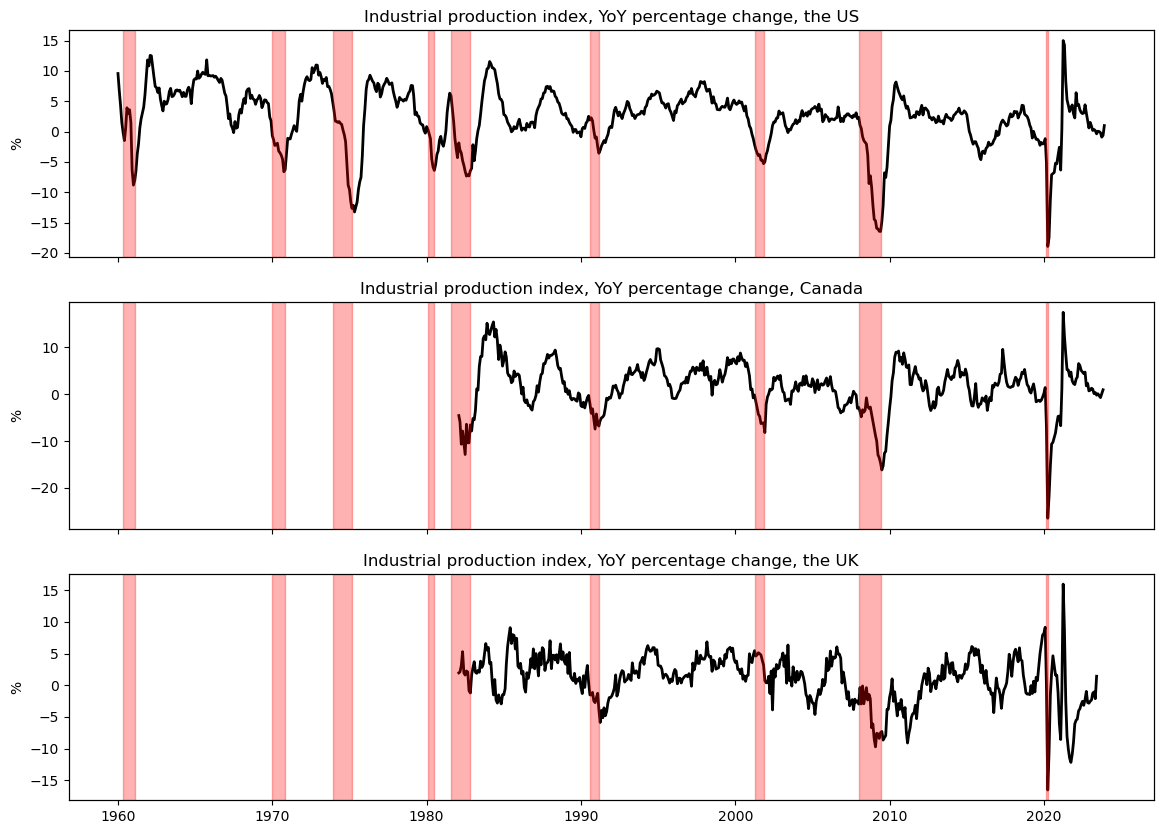

In [452]:
plt.rcParams["figure.figsize"] = (14, 10)

fig, axs = plt.subplots(3, sharex=True)

axs[0].plot(indpro_yoy, label = 'Industrial production index, YoY percentage change, the US', color='black', linewidth=2)

axs[0].set_ylabel('%')

ax0_r = axs[0].twinx()
ax0_r.set_ylim(0, 1)
ax0_r.yaxis.set_visible(False)

for start, end in regions:
    if int(us_recession.iloc[start]) == 1:
        ax0_r.axvspan(us_recession.index[start], us_recession.index[end], color='red', alpha=0.3)
    else:
        ax0_r.axvspan(us_recession.index[start], us_recession.index[end], color='blue', alpha=0.3)
 
axs[1].plot(indpro_yoy_canada, label = "Industrial production index, YoY percentage change, Canada", color='black', linewidth=2)
axs[1].set_ylabel('%')

ax1_r = axs[1].twinx()
ax1_r.set_ylim(0, 1)
ax1_r.yaxis.set_visible(False)

for start, end in regions:
    if int(us_recession.iloc[start]) == 1:
        ax1_r.axvspan(us_recession.index[start], us_recession.index[end], color='red', alpha=0.3)
    else:
        ax1_r.axvspan(us_recession.index[start], us_recession.index[end], color='blue', alpha=0.3)

axs[2].plot(df_uk_indprod_yoy["IOP_PROD"], label = "Industrial production index, YoY percentage change, the UK", color='black', linewidth=2)
axs[2].set_ylabel('%')

ax2_r = axs[2].twinx()
ax2_r.set_ylim(0, 1)
ax2_r.yaxis.set_visible(False)

for start, end in regions:
    if int(us_recession.iloc[start]) == 1:
        ax2_r.axvspan(us_recession.index[start], us_recession.index[end], color='red', alpha=0.3)
    else:
        ax2_r.axvspan(us_recession.index[start], us_recession.index[end], color='blue', alpha=0.3)

axs[0].set_title('Industrial production index, YoY percentage change, the US')
axs[1].set_title("Industrial production index, YoY percentage change, Canada")
axs[2].set_title('Industrial production index, YoY percentage change, the UK')
#axs[0].legend()
#axs[1].legend()
#axs[2].legend()

plt.savefig("Problem_identification.png")